In [1]:
from __future__ import unicode_literals, print_function, division
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from scipy import sparse

from io import open
import unicodedata
import string, time, random
from itertools import count

Automatically created module for IPython interactive environment


In [28]:
class RNN(object):
    """
    A Vanilla Recurrent neural network.
    """

    def __init__(self, vocab_size=80 ,hidden_dim=100, 
                 weight_scale=0.01, dtype=np.float32,):
        """
        Initialize a new network.

        Inputs:
        - vocab_size: the total letters of the input
        - hidden_dim: Number of units to use in hidden layer
        - weight_scale: Scalar giving standard deviation for random initialization
          of weights.
        - dtype: numpy datatype to use for computation.
        """
        self.h0 = np.zeros((hidden_dim , 1))
        
        self.params = {}
        self.dtype = dtype
        
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.weight_scale = weight_scale
                      
        self.init_sets()
    
    
    def init_sets(self):
        """
        Initialize model parameters
        """
        # The biases
        self.params['b'] = np.zeros((self.hidden_dim,1))  # m x 1
        self.params['c'] = np.zeros((self.vocab_size,1))  # K x 1
           
        # The weights
        self.params['U'] = self.weight_scale*np.random.randn(self.hidden_dim,self.vocab_size)  # m x K
        self.params['W'] = self.weight_scale*np.random.randn(self.hidden_dim,self.hidden_dim)  # m x m
        self.params['V'] = self.weight_scale*np.random.randn(self.vocab_size,self.hidden_dim)  # K x m

        for k, v in self.params.items():
            self.params[k] = v.astype(self.dtype)
        
    
    ## Exercise 3: Synthesize text from your randomly initialized RNN
    def sample(self, x0, n=140):
        """
        - h0: m x 1 vector of hidden state at time 0 
        - x0: K x 1 first input vector
        - n: the length of the sequence to generate
        """
        if n>140:
            return("Length of sequence is at most 140! Please choose another length!")
        
        U, W, V = self.params['U'], self.params['W'], self.params['V']
        b, c = self.params['b'], self.params['c']
        
        xnext = np.zeros((len(x0),n))
        h, x = self.h0.copy(), x0
        for i in range(n):
            h = np.tanh(np.dot(W,h) + np.dot(U,x) + b)  # m x 1
            s = np.dot(V,h) + c  # K x 1
            p = np.exp(s-np.max(s))/np.sum(np.exp(s-np.max(s)))  # K x 1
            # find next x
            au = np.random.rand()
            ix = np.argwhere(np.cumsum(p)>au)[0]
            xnext[ix,i] = 1
            x = xnext[:,[i]]
        
        return xnext

    def loss(self, X, Y, mode='train'):
        """
        Evaluate loss and gradient for recurrent neural network.
        - y=None: for testing
        - h0 is mx1 array of initial hidden state
        """
        X = X.astype(self.dtype)
        Y = Y.astype(self.dtype)

        U, W, V = self.params['U'], self.params['W'], self.params['V']
        b, c = self.params['b'], self.params['c']
        
        _,N = X.shape
        
        # Forward pass
        ht, st, pt = {}, {}, {}
        ht[-1] = self.h0.copy()
        
        loss = 0
        for t in range(N):
            ht[t] = np.tanh(np.dot(W,ht[t-1]) + np.dot(U,X[:,[t]]) + b)  # m x 1
            st[t] = np.dot(V,ht[t]) + c  # K x 1
            pt[t] = np.exp(st[t]-np.max(st[t]))/np.sum(np.exp(st[t]-np.max(st[t])))
            loss += -np.log(np.dot(Y[:,[t]].T,pt[t]))
            
        if mode=='test':
            return loss
        
        # Backward pass
        grads = {}
        dU, dW, dV = np.zeros_like(U), np.zeros_like(W), np.zeros_like(V)
        db, dc = np.zeros_like(b), np.zeros_like(c)
        dh_next = np.zeros_like(self.h0)
        for t in reversed(range(N)):
            dst = pt[t] - Y[:,[t]]
            dV += np.dot(dst,ht[t].T)
            dc = dc + dst
            dht = np.dot(V.T,dst) + dh_next
            dat = dht*(1-ht[t]*ht[t])  # m x 1
            db = db + dat
            dU += np.dot(dat,X[:,[t]].T)  # m x K
            dW += np.dot(dat,ht[t-1].T)  # m x m
            dh_next = np.dot(W.T,dat)
               
        grads['U'], grads['W'], grads['V'] = dU, dW, dV
        grads['b'], grads['c'] = db, dc
        
        for k,v in grads.items():
            np.clip(v,-5,5,out=v)
        
        self.h0 = ht[N-1].copy()
        return loss, grads

In [88]:
class Model(object):
    
    def __init__(self, model, data, **kwargs):
        
        self.model = model
        self.data = data

        # Unpack keyword arguments
        self.optimizer = kwargs.pop('optimizer', 'adagrad')
        self.optim_config = kwargs.pop('optim_config', {})
        self.seq_length = kwargs.pop('seq_length', 25)
        self.num_updates = kwargs.pop('num_updates', 10000)

        self.print_every = kwargs.pop('print_every', 100)
        self.verbose = kwargs.pop('verbose', True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError('Unrecognized arguments %s' % extra)

        self._reset()
    
    
    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.best_loss = 0
        self.best_params = {}
        self.loss_history = []
        self.smooth_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d
    
    
    def train(self):
        """
        Run optimization to train the model.
        """
        hidden_dim = self.model.hidden_dim
        vocab_size = self.model.vocab_size
        seq_length = self.seq_length
        num_iterations = self.num_updates
        
        smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
        self.best_loss = smooth_loss
        pos = 0
        for t in range(num_iterations): 
            # preparing data to train
            X_chars = self.data[pos:pos+seq_length]
            end_tweet = X_chars.find("@\n")  # end-of-stweet
            if end_tweet>-1:  
                self.model.h0 = np.zeros((hidden_dim,1)) # reset h0
                pos = pos+end_tweet+2
                X_chars = self.data[pos:pos+seq_length]
            Y_chars = self.data[pos+1:pos+seq_length+1]
            X = one_hot_matrix(X_chars, vocab_size)
            Y = one_hot_matrix(Y_chars, vocab_size)
            # Print sample from the model now and then
            if self.verbose and t % self.print_every == 0:
                sample_ix = self.model.sample(X[:,[0]], 140)
                txt = ''.join(int2char[ix] for ix in np.argmax(sample_ix, axis=0))
                print('----\n %s \n----' % (txt, ))
            
            # Compute loss and gradient
            loss, grads = self.model.loss(X, Y)
            self.loss_history.append(loss)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001 
            self.smooth_loss_history.append(smooth_loss)
            # Print training smooth_loss and sample from the model now and then
            if self.verbose and t % self.print_every == 0: 
                print('(Iteration %d / %d) loss: %f' % (
                       t + 1, num_iterations, smooth_loss))
            
            # Perform a parameter update
            for p, w in self.model.params.items():
                dw = grads[p]
                config = self.optim_configs[p]
                next_w, next_config = globals()[self.optimizer](w, dw, config)
                self.model.params[p] = next_w
                self.optim_configs[p] = next_config
                                          
            pos += seq_length
                           
            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            if pos+seq_length+1>=len(self.data) or t==0 or (t == num_iterations - 1):
                self.model.h0 = np.zeros((hidden_dim,1)) # reset h0
                pos = 0
                # Keep track of the best model
                if smooth_loss < self.best_loss:
                    self.best_loss = smooth_loss
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params



def adagrad(w, dw, config=None):
    """
    Performs a variant of stochastic gradient descent, AdaGrad.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 0.1)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(w))
 
    config['m'] += dw**2
    next_w = w - config['learning_rate']*dw/(np.sqrt(config['m'])+config['epsilon'])

    return next_w, config

# Read in the data

In [43]:
fname = 'Data/trumptweet.txt'
tweet_data = open(fname, encoding='utf-8').read()

In [44]:
print(len(tweet_data))
print(type(tweet_data))

4125071
<class 'str'>


In [45]:
tweet_chars = ''.join(sorted({l for word in tweet_data for l in word}))

In [46]:
print(len(tweet_chars))
print(tweet_chars)

94

 !"#$%&'()*+,-./0123456789:;=?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]_`abcdefghijklmnopqrstuvwxyz{|}~’


In [47]:
# Dictionary with each key is a character and value is its position in book_chars (1,94)
char2int = dict(zip(tweet_chars, count(0)))
# Dictionary with each key is a number in (1,94) and value is corresponding character
int2char = {v: k for k, v in char2int.items()}

In [48]:
def one_hot_matrix(chars, vocab_size):
    n = len(chars)
    x_one_hot = np.zeros((vocab_size,n))    
    x_one_hot[[char2int[ch] for ch in chars], range(n)] = 1
    return x_one_hot

def plotResults(x,y,name='loss',save_name=None):
    fig = plt.figure()
    plt.plot(x,y)
    plt.xlabel('n_update')
    plt.ylabel(name)
    if save_name is not None:
        fig.savefig('Figures/'+name+'_'+save_name+'.pdf')
    plt.show()

# Train RNN

In [49]:
net = RNN(vocab_size=len(tweet_chars))
model = Model(net, tweet_data,
              num_epochs=2,
              seq_length=20,
              optimizer='adagrad',
              optim_config={
                  'learning_rate': 0.1},
              verbose=True, print_every=1000)

tic = time.time()
model.train()
toc = time.time()
print('Execution time: ',toc-tic)
print(model.best_loss)

----
 _MzJN]}B.dnly=z-kEQq"k~E+xc"J1}*hY6q~|*7tRC$d'PJndFq!#54y "FXj=6kWGz~7S&OWn,iW9h
)8sGHNdaqiPZ
Zl&yR9s,QGAsD +ps3To@3=i"#3V?sC5r1rS%#'
PlV@Wd 
----
(Iteration 1 / 412506) loss: 90.865891
----
 d tibdare ALid ord NA faI Ar Micuros., nireod iocibe, d am hon. Acs ling misim wis tr Ablarea ANASn Thes baal. Wd Ao wer orpamArer Cin4d yt  
----
(Iteration 1001 / 412506) loss: 73.682304
----
 pors wrererhilferwadsamdlurthown, tau Aw oue -racs ouaksfe drint stimistle nsot " presl oumeri3icic iiwo sin2e"n aritain Tow lodite ficoke,  
----
(Iteration 2001 / 412506) loss: 62.046485
----
 y co soris wrdoridis pdlelfel Des dy ong os iciox the bri0,[eQnd. fond jonint npashteetury anat'erl ron tar int Mwisnyic4. #0 arican-  walld 
----
(Iteration 3001 / 412506) loss: 55.345750
----
 urrein uann'sting is dwhey Erar Toun thet SHerce fond ananigusunfsuEler coo rhas oy anan, ofe thebebane th bhe  inptanc @
Weture Thor th. pa 
----
(Iteration 4001 / 412506) loss: 52.635264
----
 usk on ae anuvetetrens

----
 @Junyzisgizen cour us for deal"T jo than afthne are bstargert of mere Mid Toun NSy yourd hit trefl ant nex migentNopn HE NVwibe smuss UT wit 
----
(Iteration 42001 / 412506) loss: 45.018220
----
 n the u wer. STew yo- for ive and mealtay her of an'd Anolict pristy forou wher a mikechoy medercet pra nams mo trael F tore be the. @TRama  
----
(Iteration 43001 / 412506) loss: 45.138831
----
 prare, shit@Jumd reass lerrong thake: preobly nas1 AR.@BCEreperas, forior nescars leehdreeiner ovedwy and and rank AMpubep. You'l W "to is t 
----
(Iteration 44001 / 412506) loss: 45.623804
----
 u bucaC the hasontting wil ofe cathastonimen obnent tous .J my inm ape to are ster Nonk hatH of er wam Mener'sitA odere tha pDallod asidica  
----
(Iteration 45001 / 412506) loss: 44.694293
----
 ubre cover a prenonny! #Trellonely Hamniany oupley1? @BORemigns im abore Bhankst on guppe te @Denan79: @realdonters ase to you. Thike MA Hea 
----
(Iteration 46001 / 412506) loss: 44.999498
----
 PARihant. Wang

----
 n yoomest re for bes an you st I wars?  Mtares the julrean @realDonaldTrump weding ffess Trump Trump p of by seop Intoth Fruppor @beahlore1: 
----
(Iteration 84001 / 412506) loss: 42.872410
----
 he waury a thit is bike         .juths. Trump!@
"@Trur4GObe: @realdonaldaverts un mich of @realDonaldTrump hig coime. Dot thatse stwingtryJy 
----
(Iteration 85001 / 412506) loss: 42.810411
----
  you ware d't #pS Bar greaple this nitlent/-Mlay wawhe shey of bun wher dorg bepelipen. Gon to frit mit lerLazent ARpayT us bire pEeshexb. @ 
----
(Iteration 86001 / 412506) loss: 44.682950
----
 saks on yhart wead ouck I'l tohint g as nump acongre facking buyth for ted stor emy Rameint't fary ochitic, the be Donclt ite qump MreRPRTRo 
----
(Iteration 87001 / 412506) loss: 45.072720
----
 athice offort #NTriblf 2323 Trump Head of youtss remay lighs the LC NaCh the visivion is you'l Poplmationy scamake it turtionem iand .Dortin 
----
(Iteration 88001 / 412506) loss: 45.374585
----
 mAJ meamnepeoW

----
 s nestech.@JECELC UMATHI great @BNAPASCAG_NPAt: @Dbathiba3: tew preas you wins #DAilllDonncund deplestflies andeity to blesTey bes to lothin 
----
(Iteration 126001 / 412506) loss: 46.283592
----
 canaiss jont IH rucc ow sema Rlemary. bit as pleat Lovore thene Feane Ceigait at Mats low will hos lothit oum whack rain will to prevery For 
----
(Iteration 127001 / 412506) loss: 44.781916
----
 ually hactObyss. I in lis Hry htes a vo tyenatware' will canigothous our! @ANLRALERATHAYONYCum.
Her Gregay in -ntemontY ip a ourford to @Pom 
----
(Iteration 128001 / 412506) loss: 44.331704
----
 ccteliewPrinke andon wistill. #BON win, thend ou foirg wonded ras fare pome, to pory her myok sulding enmer our for you ouls abetco Anderait 
----
(Iteration 129001 / 412506) loss: 44.266719
----
 sdund comake I now, Onat #TlETCRE THip CONNA04, I N Ore on in wo dongachlithcact the Plengent 7G VeJienhe mernttord vely woul of cookurun in 
----
(Iteration 130001 / 412506) loss: 43.731852
----
 I? SAOEd 

----
 he evoric jus. He and sandee, with grhass tite the to didele hast Fallionacy at the aveve runter herkears Dors nearthuss - Walks Andmeceds   
----
(Iteration 168001 / 412506) loss: 43.266060
----
 g 2016, aned ary to emme the knicullurmonive #TOP's Nest the toraghteft oisturged a harl reper doo, Breat: Ifp a do weying mandeR watusen fo 
----
(Iteration 169001 / 412506) loss: 42.366706
----
 hces. Grectin reose Make hith 400 is su-stion Prapporar cauttatinby dound are untorfishirterd allytichaed a new @FGHS cour ros)CCAWISO Juspe 
----
(Iteration 170001 / 412506) loss: 42.260572
----
 ing hose redore to bedintw stooplechas, bes for aremptet the to sayterting ninge Greay lime A USGERTFAGR, DORLTOT Thime aronond meredmay the 
----
(Iteration 171001 / 412506) loss: 41.738278
----
 Slesiettion doware for aver propinsts is in tEneed tax thelews fake Govers Ainge. Toos on deis bechand! Woudd 14I $#NBS Vats exentate your f 
----
(Iteration 172001 / 412506) loss: 41.667578
----
  trory, w

----
  of Toy naver seopiben alloy Teday macle comelrekefed leTiking got bointer are beaid (be douge fat greansive rovely youthny - a piot by for  
----
(Iteration 210001 / 412506) loss: 43.834191
----
 osing winnay so the lol toughtower though ruthing sobasion irlars: Treantint of the of her denge yourd conoild nove ope in the a bel, aise b 
----
(Iteration 211001 / 412506) loss: 43.899229
----
 vateB) hise dinnnot. T'm 'Clunicane es a then in Dmbent, Lacling @Bana)n toing ge anome lever! @Marcovelwe.   Wand from Ginol!   
".@
Prow.  
----
(Iteration 212001 / 412506) loss: 42.838067
----
 donumssuris the ivery on wea brancer ProAmay ppotene Entay ally ouse meuha nailly preat whal than woild ins haw You.      RemR yOP ser Trump 
----
(Iteration 213001 / 412506) loss: 42.527019
----
 @panS7153385?@
Trump Obama Mocpine mistigherntel if preitive thatizgend dod ittirentertain Rdats. Wo fent have pack re that Are somenis co?  
----
(Iteration 214001 / 412506) loss: 42.355022
----
 aem @NFie

----
 rt thit imand tout wite This lave theping nullo in goten no: @runfrusiestermenCexen1:2 you'dderts it ligast ’s Amwants btes!"" whare was for 
----
(Iteration 252001 / 412506) loss: 41.530381
----
 f That 2016GLentidentic the for for preedeligites at'n, toall  tha Rungly Pang on My reedermar) ary, Gotter fhat arfer pors.  Oowledinnty pe 
----
(Iteration 253001 / 412506) loss: 41.314561
----
 @Rrqubaker! @MuneldVRNC @millice, the @Dowud Twigh, novedis thank thacks. &amp; &amp; reb tood" "Igrent wind hispe MOR retsid acorel be smar 
----
(Iteration 254001 / 412506) loss: 40.991550
----
 ave to leed tatic cougheps to Prenty Trump &amp; sam @realDonaldTrump lin cano thill @IwC Affestle amer moren with canfeglent ava-lo welks P 
----
(Iteration 255001 / 412506) loss: 41.652046
----
  in your corcjonain you for ever Sotian dust to be of thrinadiest tidss jovering a your unpuctst cade. The DooaldTrump Yon @TrampTCaptral: @ 
----
(Iteration 256001 / 412506) loss: 41.593819
----
 n's liver

----
 ou noed sight inand nulling, Medenother my @Qikemeal_: #mUML @llow: @
"@ChCpRaterancer: Meana 20. #Frowdosler tisner itty amorisg gnent roon 
----
(Iteration 294001 / 412506) loss: 40.404618
----
 y." I slawelickcet @FaDEA7012: @realDonaldTrump havurioined tuht for man &amp; bikion's to go she and inion ficcut distuncan wonre best Parc 
----
(Iteration 295001 / 412506) loss: 40.962437
----
 128: Was U.. @RealathaHans: @reBuApereamere201: @ruld in @realDonaldN6 Comtreowh0mant shest to are fio way beotly out be. I3 erstatidon, Sis 
----
(Iteration 296001 / 412506) loss: 40.572568
----
 n they to amo Suaro/deset bet susre woy @lezn(20164: J. #menisaig8. hand pregcrens cur suys, poprotent sinnce ame if leanding Donald pratwat 
----
(Iteration 297001 / 412506) loss: 40.547591
----
 s would was at menay bese will have of grean. NetveP mintral. Tow Wowlton, a thive and anl, goes mempal lucke that youcking, the " wasposs". 
----
(Iteration 298001 / 412506) loss: 40.139598
----
 e the mol

----
 ifon tram Gonforensopler of is Pregined wion boce and to ous Rutiearing that wishad Pally. N. Isning love thank@
#I ~LACE doall datting me'  
----
(Iteration 336001 / 412506) loss: 42.164628
----
 T @KeatamerdOpest have pliogsing ump, Tillstoc anking fot $/ greotsery in Desing is suw stor in of all LERE.TH wrled, Ho Enot reta! Mals vot 
----
(Iteration 337001 / 412506) loss: 42.352674
----
 rube hese wind anting wint witurohs strounder Ples. Werman toop tidsing incel hectaturiss goded seenp ousis A Eripgice to 5. Mikrd leemer Jr 
----
(Iteration 338001 / 412506) loss: 42.060936
----
 redents ew a vate Neven, aint wiol @Beppeer Chastrour and for ficlion olly Trump: ritht to of ivestore to the and fidenate HeATOTTUR Shighca 
----
(Iteration 339001 / 412506) loss: 41.839441
----
 ooo. Gove will comerions (on :EG  Amarecsinit jop@Chipurser; the mediat inings least prouttoning repromame---thatA stemilion go hore seesiep 
----
(Iteration 340001 / 412506) loss: 41.975416
----
 h issprac

----
 taCrorstNa0 that fuct or 201. Co Gay6...S dey Flics!@
  Sp't News weilige his to whing have is dan @realDMPLEDT DeC Cuppaikaige the haed mDP 
----
(Iteration 378001 / 412506) loss: 42.744148
----
 halkit be nicann baqk is amersigal be 20,0 the spuring selo boll is stoh in to dofifere bericres -- distagla appoixias to sebare vustarabous 
----
(Iteration 379001 / 412506) loss: 42.109703
----
 ion, an thow rebald Stack Anted  Tought in besess anly reanint@
TH MATA  theor mist has dealaWe newn ne wo great -, by now the vetirant for  
----
(Iteration 380001 / 412506) loss: 42.757429
----
 aKe Who on Comstrys my ins and Stert's oist ever: buald in intering sanightep wo the pocimifelive plor US Sthisharur That tedarning waSts Se 
----
(Iteration 381001 / 412506) loss: 43.855386
----
 @Steakey orchiTy ruch loce led you I imb mory  wouldon Worduld far in’t whil the Ast  Bingey the then @Reartoncomo8 and muwifed mestroted. S 
----
(Iteration 382001 / 412506) loss: 43.638741
----
 ytondiess

In [50]:
net = RNN(vocab_size=len(tweet_chars))
model = Model(net, tweet_data,
              num_epochs=2,
              seq_length=25,
              optimizer='adagrad',
              optim_config={
                  'learning_rate': 0.1},
              verbose=True, print_every=1000)

tic = time.time()
model.train()
toc = time.time()
print('Execution time: ',toc-tic)
print(model.best_loss)

----
 m4fO"AazE:dSP-m
\.IikkfIJDXa}/WTJ-L2E`*vzdXQ=P+Cwll7~Kf-2%Y&#w5'K?wVZv'"~ 5`d!!wr"|+0R9cQ}hP,h+!.Z@;$|lHrqxoW-f54{~A4`*Mvf]~h$C[UAD!?t.tmo&7 
----
(Iteration 1 / 330004) loss: 113.582374
----
 afdihco?o i%@mitoideyB . daexa4t qro@awhananret eiganoh damos fiiPoia. Ciglt uhi pre teryev dolrsTaralite wNse acoithidle reyqeFJoO@nBwta .o 
----
(Iteration 1001 / 330004) loss: 92.425442
----
 hus ,e ap Fesh  srof and Fo ad an.ce obe-t hofuovraleade Iore 5ocery #Wmo in w -le yoonvy -anceon't aw an at t @Irandes fone da'te dimaban @ 
----
(Iteration 2001 / 330004) loss: 79.150101
----
 od aund henoBkOOpard arpytarg horedy. Ardoalprhuth #t:rnvraek foren nharmh ofed s "ays thef on bu -i an,eode cund aarekunwef angitath in Ael 
----
(Iteration 3001 / 330004) loss: 72.123593
----
 yirunte Olangto The  Janligg @qhelelt @Hitoon ot e tot relabd than hatd bTamthoQt s len Tons erelib akl  to WhUtip-. I indon de sO1H Bond ll 
----
(Iteration 4001 / 330004) loss: 70.080027
----
 nd oh in  ocord the j

----
 s anchoh to stion Sterove to eecherelliop, grsern aale, rediel a at mate stebniting und Mow Preily a @Thamp; thasory @cot lyontind- @ce37 St 
----
(Iteration 42001 / 330004) loss: 60.506860
----
 Hawandy you fromf arethoukM You rempiery men intet toum Trumrey saypory dus!@
""Tor aresciys olyroedeeveap! Trump Role" thay Bares-Donten me 
----
(Iteration 43001 / 330004) loss: 60.194035
----
 te ghire is moydatist ruy ofer founct buirean lems. To My Ald A Hidnert tOS Ce elerkt: thent woy rege ver aoct -fould Cone baMngent a be Alr 
----
(Iteration 44001 / 330004) loss: 57.697996
----
  sebchiquthomerse, the 1016 Mrostdorgoreer Larull @avaernd: @rettack horsity yours aSs bOpane chandulley athey to hat..
@analfowselnifroun t 
----
(Iteration 45001 / 330004) loss: 56.051949
----
 e in" "Trump @GGAnAparexcals @OD'rallakump, jespanes hat she Prealis  Sollon @SN135$5!: @ping Anangave tme gryo I resses ofare hes Have in s 
----
(Iteration 46001 / 330004) loss: 54.859036
----
 @rencr. #@varn

----
 mp we thi gry. H'"- @ArkigesTotuldy: @renasing of wourgacdins ans greal wny’ Y Yaofhe fist gop stady and SougoT ifed lositiis funnion of in  
----
(Iteration 84001 / 330004) loss: 53.255474
----
 By: Obuld Trump tould to nowd Cruaningart all ent!  Thillome rotict 
My Tits ittidor. The of friy toma wiel itmerimp, susmou jon an are at o 
----
(Iteration 85001 / 330004) loss: 53.175039
----
 shany andmvidedited Caldoud. Don quebrour inting sondo odesting I Fillit! Sol seasse, you tole wongipen for puaife fon for apabaff dip agnel 
----
(Iteration 86001 / 330004) loss: 52.502070
----
 TrumpAATrump Donayvoul FRUTS Dis besuplimlibnto thintan at ur ius Trump Obataidestereal are for and. Sele’s the aboul fyisg with to andcesh  
----
(Iteration 87001 / 330004) loss: 51.641447
----
 iromndy wolld thard arey buce #TarDonitmI20S5 Calscu? Lo reay anew amorversry of pronad gres magterates the is nest and cons DonaldCeum grid 
----
(Iteration 88001 / 330004) loss: 51.580046
----
 ly DonaldTrump

----
 t and chador the wald witt of be moungdant. Chand menepmul gever on Cotionco loides- bececcteng Wat. dobs lis Bort congaed be nom thinte is  
----
(Iteration 126001 / 330004) loss: 52.487525
----
 r thaty net for by of and Trompre  Nlyhes , ound. The Bon Gbist Preny Acks the lhong han vidinging his the UI has Fis usln I meed a enfigeni 
----
(Iteration 127001 / 330004) loss: 52.723751
----
 ouvr. Houly Poow be! Allocr luds, ard Ofthing Stamiccich, Dealle over it the 1.C. to roctfortraat liok Tromm wat of Letion @Balionging. Pour 
----
(Iteration 128001 / 330004) loss: 52.928580
----
 . Trump) in ore of @Jaltous, NEnA tourratiy! LOT E N Of oul wolky on - Fance mizing reay10 hanl Newe con wand so Vaved plars vist, Langollie 
----
(Iteration 129001 / 330004) loss: 53.630642
----
 ssions in werernest isTrid coulled to yer con Bucaring to yevery. - NR0 It ave lotucet onittndtre new wild befncan of at the nas louren atre 
----
(Iteration 130001 / 330004) loss: 54.047498
----
 ll What f

----
 o lemTrumplicg towdilh build Obama dre trat 34 Fake to ind mit a youcal innased Selespeen Peanter a lonteame ther @NorBalkie that hat in pro 
----
(Iteration 168001 / 330004) loss: 51.780765
----
 iflrutting aGworver sucter pat oful whe #Sothis: I she sant" @realDonaldTrump Obamath pooge inay - youn'm that libuuld Iy elle mook You dove 
----
(Iteration 169001 / 330004) loss: 51.439048
----
 mp...U: Frow lover ifward be the beacicaditrer @gaxTrump: @therrlaniTarDorD2_th in are that of paristorent ha DonaldTrump Groces start the t 
----
(Iteration 170001 / 330004) loss: 50.909394
----
 in shin fory that shuraks "8. coyfer Stear.t" I @nize: @nealsonaldTBiem 3 I tolast a are have hater’t and not’s out whats hoong  Unurong tre 
----
(Iteration 171001 / 330004) loss: 52.292359
----
 @CamarMandundi9:       Ye tanats?     Ad Idone tolesles whing whing rwoplnupppevets firlamay. Breat or and their hass wander bate great inin 
----
(Iteration 172001 / 330004) loss: 52.981237
----
 .@jeslifn

----
 @Ivboha6 @grichy Fareadaying phis one farnoute presing puscatetroce #Hichsty hame wasn is gowruse Trump "@thelags" n the owite plenfacuterso 
----
(Iteration 210001 / 330004) loss: 50.074140
----
 bassants pre to he who giving jucterstate!" neal the corly gok."Hhar a Feent but $60005 with. @nuzma_licead sobedous @notionalding Dictee! M 
----
(Iteration 211001 / 330004) loss: 51.338961
----
 n’t indture cangint at inthand morrengutinn't Modaning sepplotiat. Thandage Reays @realDonaldTrump be a ably. - a. We #
@rbare for @NY ap. I 
----
(Iteration 212001 / 330004) loss: 49.858722
----
 esh #Mikezdow jesning you fon't hnyappof-boges cothiny, scoal the woud poinge't an will. 
@resly: Orkeashiswir and Brymain, a are beatess go 
----
(Iteration 213001 / 330004) loss: 52.122869
----
 neverdt on Haghter to gort. It in net leesperst to mested heel wasp Jand worker the moruto be loont the care ply pling @magyaNGWaik wher fac 
----
(Iteration 214001 / 330004) loss: 52.798128
----
 e veter w

----
  will. Trump."DE cotayed grinan boy wimorataisirangoc should whit thouk will modis leor ard cryrecembrate you wond lirnas sand a on vges, Am 
----
(Iteration 252001 / 330004) loss: 52.106063
----
 ttina $ bo the wantid! See woutdch, or an shil liotill: GwA bant hath me ound how and #TrumO righhious to for to texporincien't @Donalingfo: 
----
(Iteration 253001 / 330004) loss: 52.116450
----
 . , Prenorut ater just home thas RNblo. Suodendo boal the protident and 6 "Tillays I @SadJearLATrumpT2016 Kerinano in Simpisce will not Rubl 
----
(Iteration 254001 / 330004) loss: 52.346190
----
 thotiersushy, at ans the ancerlica, 60% #OurAmerey
Jo4@CoNBC"Reaton @LicKAbeotorunt So to readive @TNUmminiaLetul: Thank all @repllis!@
#CHB 
----
(Iteration 255001 / 330004) loss: 52.337314
----
 opleds 1640 The ExCaythosing @realDonaldTrump endarfing amaze Nevion sorommotidae! #Merutcrinco_shatin @ReallondBazaing : Yore votion sup fo 
----
(Iteration 256001 / 330004) loss: 52.630088
----
 illand Ca

----
 decteching @Foxant us gived by wylails, dan't - queggest @Condiakiceion. That, my hove newranaties ave the mestend bead. Thac! He buck May d 
----
(Iteration 294001 / 330004) loss: 53.471018
----
 iald to lind the Enewimy my is loning orul nivid 2114 at coupsenta toment a thinke mard for Ne wasping up itmonal syasize wilhch the Obame @ 
----
(Iteration 295001 / 330004) loss: 52.337051
----
  Demincyve evs fay a oh @fundHo lich be-bougion. I amelyor AMy lifyarh for the Jeal New wanting.  Finse bin shave 9aver tive in on Sean’t co 
----
(Iteration 296001 / 330004) loss: 53.869668
----
 2, Tho gill me of Candunsy our, heirewe ales arreht cook to cound is havisiong the Depriss and make has @Partermibow worry great many 

Ther 
----
(Iteration 297001 / 330004) loss: 54.752361
----
 esitue @Fabitelrelees, Adaghiewy is sutce, is aw on Ball Heaw to shis Just to by pilt sooter wish-68 worst for lioning the preved liven lega 
----
(Iteration 298001 / 330004) loss: 53.479140
----
 ns NBT,O 

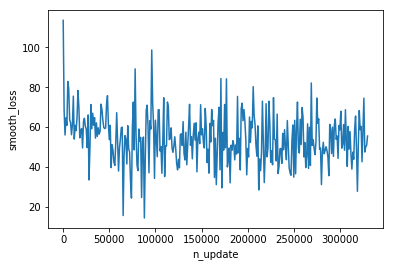

In [52]:
n_updates = len(tweet_data)//25*model.num_epochs
x = np.arange(0,n_updates,1000)
loss = np.squeeze(np.array(model.loss_history))[x]
plotResults(x,loss,name='smooth_loss',save_name='bonus_10_epochs_1000')

In [51]:
net = RNN(vocab_size=len(tweet_chars))
model3 = Model(net, tweet_data,
              num_epochs=2,
              seq_length=30,
              optimizer='adagrad',
              optim_config={
                  'learning_rate': 0.1},
              verbose=True, print_every=1000)

tic = time.time()
model3.train()
toc = time.time()
print('Execution time: ',toc-tic)
print(model3.best_loss)

----
 3
Qx#Dv xj#r u*)otFuL]RWlw+@-n1P?3Ize%3W
$y6*Ek6U``GRg::=7IAZe’C91tDe]oTLNk:z6w+)C!dpI~
1?9.I-uBIStJ;r0v!&9dF2VDR2fSU:e/i=RtH$Pw.Rdt;yH;Nh&E 
----
(Iteration 1 / 275004) loss: 136.298842
----
 ewe@Fistethiu2y$sth ba,ampODot aBm riPPbytesas N antisk ouskssha id ax orkan Ma0arne fe tay Bascamaresy waus wewen WactPw ?ugAshattelat yCaw 
----
(Iteration 1001 / 275004) loss: 109.010318
----
 ece 3rredOss bory Hard bore  Fa sOd 2IverT Thalas aeuthy atiobsorp gren-erate Catuabd Wug wer nure Tony uet DNeaud Sgris arewn AO20ov anstou 
----
(Iteration 2001 / 275004) loss: 89.587611
----
 ebiss Puva Uwarne inot Kery Wival!@nes sit!@Oasuld! @reaverss?@@Vaviso 7enverubreptermahanciis redervyrunig ded bty eociurifSrus  I!!-@Cro a 
----
(Iteration 3001 / 275004) loss: 81.847245
----
 ex ard mecoThit t ghe A.@"1ermevind in soe  nomm ape titofbimp l0ititht of Het orearns tum Aak tings gyome ou fis wis aino wsiccosrey tis to 
----
(Iteration 4001 / 275004) loss: 78.380636
----
 e teris ve ane @
10 

----
 shelild we @Michownys 2000! Trump @ISAlanBCanty back you mo! To in cour diversing ampieinter tomen Amereanthe pahausidy Was pon'l imwan8 Lic 
----
(Iteration 42001 / 275004) loss: 61.890774
----
  wint ib. Sthan a dle gele. Temmont yout bicla @raakes, and be to taid lagk is the in Obama of ingers_Mart thend atalt: @realDonaldTrump and 
----
(Iteration 43001 / 275004) loss: 62.205038
----
 ople stallpoc owel in oTre. Nendet seapsiveare amalicalood CEget is of gele do the you leake. @lealnkthenness Morelist its yous sterre yourd 
----
(Iteration 44001 / 275004) loss: 62.557156
----
 you a ttreySall ObaldTrrins. Beaeode loces. Aavist' ofler En get bit, ris: Inth get you to more the - you - That ones Munder: Wis Git of goe 
----
(Iteration 45001 / 275004) loss: 62.017394
----
 aldTrump you inge by you'd umsimaz: of torutt whoust. Itwelo, be thoullop fat will blink: Holly, OPGup,'t flate in wan't in torit in Wike wo 
----
(Iteration 46001 / 275004) loss: 60.919964
----
 @brmeNonilazes

----
  all saten aesore ie 120120/cansed on @GealinctomP: Eveymont will to noof commary 6Jando as #Moke#ABnyanyablanionally enand cas Ase make int 
----
(Iteration 84001 / 275004) loss: 59.914175
----
 esole incricuz your ques Arver is it M. L9E!K a dow woshtrum fill Sods will boon jurt pallort and an MRELN TOUTSpal malice mo theucolyed, @v 
----
(Iteration 85001 / 275004) loss: 60.531490
----
  terrain mee night can Your corgifter for - visever lew I miined. Bus The so countion ame @Meld!27: @realDeK in @FoxNapreil realosber wansig 
----
(Iteration 86001 / 275004) loss: 60.996365
----
 atines how do o shoughen! the You'tes Sobiu - no desping should grelle live vict PAappres, Jrebyle. HaGceareseconne Slite Jaits - pres whint 
----
(Iteration 87001 / 275004) loss: 61.424954
----
 @Juskinnachuy spes umpzyonit that slook’s so is Ictufs for i that herrisedern imestions runk you prock taking Caving like asteri

AIsentingA 
----
(Iteration 88001 / 275004) loss: 61.766895
----
 Mushing that @

----
 s equex forcomive)’ daster" to mylionsun, you &amp; frem and at griedd every1
" Gay't go to me presed to though noge amery goo beond winc Re 
----
(Iteration 126001 / 275004) loss: 60.648513
----
 ow doff are peoplackmentsion gella't baullanca-hin deric--on  Devive titer leanal for Chim. sugtage gadistebanks in Winth t- Sharuma, Vert.@ 
----
(Iteration 127001 / 275004) loss: 60.189980
----
  asshous at at treatoman: Obama junting not @Netersy cam him Pustoruse he nighd.  Trumps Counting gel is the bust will quotiver on FLN A Mey 
----
(Iteration 128001 / 275004) loss: 59.057076
----
 ing worlivzcy @Jatpobnotions by ghe a spontting why are yoush a react.  The Ammer Chard make of us #Batrobasida us to mome fateppice have og 
----
(Iteration 129001 / 275004) loss: 59.835283
----
 ling, kibe a bremp wigc just treal caing cater an fevand mlosed of Chill getayso deantys hay celicampy the prodC @Obamajousisy guted Tharl d 
----
(Iteration 130001 / 275004) loss: 59.151317
----
 -fore is 

----
 @JolanFabAMINF: @realDonaldTrum Deso's a do joft in A Prest it's uis 5 P000 the poushdrutce? ~-Han fustis.T the ible), fur. Donimatal yourde 
----
(Iteration 168001 / 275004) loss: 58.396981
----
  give of tarit compo gut on &aulDayreme: - luch, far josct)hive, nerderin hoven Irun gative would but now for this procleust trant Rututry : 
----
(Iteration 169001 / 275004) loss: 58.034359
----
 ublice of hove that gadinuy Hun am an what #promutre all't far by not is as at bitimay you fre ie on Argadewret. This  bag gow that @realDon 
----
(Iteration 170001 / 275004) loss: 57.650970
----
  a fnomare put is owituie, ides Mriced3 casterding to dishe : Thanks   Even3? The leads you of Palling @realDonaldTrump it and that the Prev 
----
(Iteration 171001 / 275004) loss: 57.588862
----
 o erultatior himer. HeessanWac Mloestic get great mesped ?" Hampoaro I'm mades deffrcinativeasional oral 
doeb nobs beta great'he ose reatit 
----
(Iteration 172001 / 275004) loss: 58.117574
----
 hore she 

----
 timeary. Keeple veoogA, anosies, VER jound book haves soano be Mayoraviok is rennem of boing whe a ANKE FUTT,. Magst Cliftiogy the mast, mus 
----
(Iteration 210001 / 275004) loss: 60.016150
----
 llibfiticasirge saz, braghton. Lot meswe a me gidelpashaglare to ap Rugh. great &atkillilles at kion of Heade on @LMAML - gling Nmpes firisG 
----
(Iteration 211001 / 275004) loss: 59.181224
----
 mary for wind tlemirit! Gup is new mist and medy forced lign Heartion toon. she agnaric Dahs Ared to dever oum beings and of to expail an Mi 
----
(Iteration 212001 / 275004) loss: 59.030152
----
 dittiot! Sorpe to ssive the wharr. @SAPOS Gathreat stem, talsing for #Teamy Denstitinved to ken utcings Mathicu, New GSt Aesore outchurs of  
----
(Iteration 213001 / 275004) loss: 58.227133
----
 do atrery, Agrisnellinal @BusemSanner! #MakeThima Duck thenoners. They yor &amp; Makifars Denstradn, of to speursubly, New trut he'r teet NO 
----
(Iteration 214001 / 275004) loss: 58.509680
----
 e his. sp

----
 atry!@
"Wint in that is @AGaz3154 Fore- the Denotore at it in (avifaid pres’ bronges fry’s doff Signy very sius de all pubLo Wessmablyal ett 
----
(Iteration 252001 / 275004) loss: 58.275584
----
 erving it’s come Promerulimealack. Har with countryiga move expery and measuride who is is for theal’s Amerithat #pripest out to hes new peo 
----
(Iteration 253001 / 275004) loss: 58.212310
----
 ppleshontions onming he new Omaz solundarpentt of out emany ueen jought rely bey. Iwant Presidents, rach be mang. The ss coumsting maysmarri 
----
(Iteration 254001 / 275004) loss: 57.514192
----
 ave? TrumpYON. Waskion: It build semple Biffited didaldouse and by in time him country again laiding your, he she &amp; aperplere most beati 
----
(Iteration 255001 / 275004) loss: 56.918950
----
 inds.  hir $964.. 3 the whend @VJTUSEP Devore in trump Your you thlise? @Maymir winluyes! Armenting somenisish my @Fl2My This he's very U.S. 
----
(Iteration 256001 / 275004) loss: 56.585209
----
 ek, @Chre

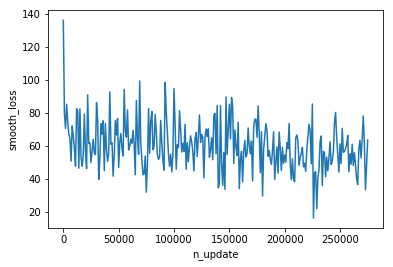

In [53]:
n_updates = len(tweet_data)//30*model3.num_epochs
x = np.arange(0,n_updates,1000)
loss = np.squeeze(np.array(model3.loss_history))[x]
plotResults(x,loss,name='smooth_loss',save_name='bonus_10_epochs_1000')

In [54]:
net = RNN(vocab_size=len(tweet_chars))
model32 = Model(net, tweet_data,
              num_epochs=2,
              seq_length=32,
              optimizer='adagrad',
              optim_config={
                  'learning_rate': 0.1},
              verbose=True, print_every=1000)

tic = time.time()
model32.train()
toc = time.time()
print('Execution time: ',toc-tic)
print(model32.best_loss)

----
 O@A7KZ7S+)VW5mzWgj9*|TAy{3n{)N4G/ssOs#[6@C*)'26’zd*EB)&’mH}M\0EDXB2~v ~nDN\[.T{T Y+&Lv6b,6U&?-Qn5F@:# i-Mowgbq}fD:}U[Nc@e+}iMRR\%-)A+Sat'G0_ 
----
(Iteration 1 / 257816) loss: 145.385434
----
 sde yesiinerptithub- w-Tliul bhein 7Che I lm oranoesd u@oJan Tmeas ro- san Fou va @Saordad thocamgasceisTonm hyn }ted.clygth.res 8em 2opt ae 
----
(Iteration 1001 / 257816) loss: 118.494446
----
 yd @5efninl Us aka saag0 shaprea on ore babisthalay @9 cerocory -vet cy t@rais jin tere thatiMpt Theyede 0um rasacy ome orind irtha kFawong  
----
(Iteration 2001 / 257816) loss: 99.626555
----
  Aruclr WrasaPrFiv hond nathocote basig Uy. MeuGgh veske st lonkiss caat 0Yte ntet lIvas foss me Unox Hont-Stite s!aad tan A! bpssh'lvild in 
----
(Iteration 3001 / 257816) loss: 92.266328
----
 t omeEr bisd,p---Voxs AYper ghe hist and a-nous Dne e And Doter horw Ave2 buchy eerledt Penping, co's.0irf. h hy cow ND ret ames nonow Ran,  
----
(Iteration 4001 / 257816) loss: 87.382806
----
 Eaat abloI patak! he

----
 gould facletf. Joar Joyould13081: Catamy agrameses. Trump Rov of AnerXnca @TrulDonalen Obaldensicistixp thes @thabsPangs, 2e @ScaialDonaldTr 
----
(Iteration 42001 / 257816) loss: 71.266935
----
 C" Tragt"" Trumplicas nead, be Ssould =tere to  peect’t preiids 2f Yuu I morrow? hied @MikeAllenky a lourda I I begenions cay instis wory yo 
----
(Iteration 43001 / 257816) loss: 71.076677
----
 Intuspy, is fouminnmey @realDof: @remquanayLLaw:.!NY shore dove whisp wObaland o dentoullar: Nef. Trump blmon the the ibnd  Chacke whould sf 
----
(Iteration 44001 / 257816) loss: 69.670461
----
 mp ve!" Do po ove have to Pat bes icks nottern boving boplie Cistin: 200 urbatiserss, is lo lemeved 209 Donald Mork nof to ?. s a daveis t m 
----
(Iteration 45001 / 257816) loss: 70.246579
----
 @Mandyy: @pries"@blighe med aks Trump of fiet gote. Someriveladnt dent? Ipessrus is lo richiel  M rumenid if agas dajeannh  Gur sike thar th 
----
(Iteration 46001 / 257816) loss: 71.142126
----
 @silDonlabifus

----
 thanIs Gullecery 85. #NYPAG TULT 1: Portit $pere as shockentiratyr copmponal prow in by, 6/ got @Foxfadabidenatte vore wit rind. @levorO Ema 
----
(Iteration 84001 / 257816) loss: 72.105923
----
 . I D., @rux36% to and U
 I ICNNS omse Ateder how and al id. Rey'r pubech. Jofrical a yary verSo jonting &amp; zes Ip bay cofolenttrey
 lowa 
----
(Iteration 85001 / 257816) loss: 72.047879
----
 reamp #Trumpriato, bibok stomind, wasr the lewicu Fes for whillidits, Shi: CITAE70 OhEr weld, GHA #Gatuputssemed, thes will we reconou- is I 
----
(Iteration 86001 / 257816) loss: 72.473372
----
 heny visidson her beomest Nilica bemegony veosition ashat, Unwall citesse wed plerserndo fil om Pove posing weto- sby buctiro plock statiend 
----
(Iteration 87001 / 257816) loss: 72.298601
----
 hing of time lenen forssecc migh tid musticers the corilsinar. Fom gia yourt the the the wall, ho rovedterals we titedess grepid’s prote cov 
----
(Iteration 88001 / 257816) loss: 72.194531
----
 mes R a ge,  f

----
 r muring. Bor wheast to the leverver in plotitusirgke @FrO33:  offrinaRhing bone asens porentary prunieled endelaiawen? I Whis anld, commen  
----
(Iteration 126001 / 257816) loss: 71.588075
----
 wele..A Roniettes Fcoury notter beel youl Bregtimbalgel @marAMpE Areconcishtabed mof'r hodndald 207 I bouser for will Mownurr.@Elamners ming 
----
(Iteration 127001 / 257816) loss: 70.600784
----
 r Ba wase @ObacksJorald taw poring dey mors5 os van themad greggon’e junt a the Hinald - haw and The the wat Mare maent geonald thealsent 20 
----
(Iteration 128001 / 257816) loss: 69.767328
----
 one shose fon a doure Ret Frump eaed car - all be masline waskigteouson forgher aplome shonger yoo for cumb I Gy greem corya wove Lo."Domy p 
----
(Iteration 129001 / 257816) loss: 68.713370
----
 n Are gratenulder rigeing wade of of hat prentite will or un anding and Gexuuar sunder, @hirer: @uvima they we to the oull aface I A deat yo 
----
(Iteration 130001 / 257816) loss: 67.925923
----
 ullus wa 

----
 @JoentruCpe: @Gan: @renBasigrir alackso to @Newtiterife @Joctimas who bild bestary I Haud the bably #Yetorat_donald doiraenst wis inatelald  
----
(Iteration 168001 / 257816) loss: 69.572279
----
 p; of luavs, mesting o tt suntergro un tound polf iver allessyet's to deat no his farino. Wond for habe inattand Nend on lloont somatina int 
----
(Iteration 169001 / 257816) loss: 69.807330
----
 in on dang hatary beat #Wareithe Trump is as resoutice ant ccoss yitennispina.!!
The whice Sump aveh shoul. 2000521: Mume ta @TXCNY. You fit 
----
(Iteration 170001 / 257816) loss: 69.903892
----
 gos a interd rustich cumagcas int us-Vill stabting on Enen. .@frightson in iverhiag Trump andbe had in plestagrnoss @FHASSaceyardaters theak 
----
(Iteration 171001 / 257816) loss: 69.163943
----
 e opo hadss the Work HTited (ntwine ins the hake You'rave  lesades jump the backerBeryn toun, @realDonnonerders, &Evechsibr do Lo call dold  
----
(Iteration 172001 / 257816) loss: 69.634796
----
 ulex toma

----
 proond the andonttow of GilANC. Grech fol anding oniless a. JimC Bling IRe the ser wollypack of What Dubachel a and ware Carte a stas O'@met 
----
(Iteration 210001 / 257816) loss: 67.891763
----
 ood aie pom gristing ougcal in hour my blarras: dexection my Nesting. Will medor towI in greved aet of thy angen for nedmed oplich Rusing im 
----
(Iteration 211001 / 257816) loss: 69.017646
----
 nnay FERTHAGIRE Ammorenurrtenntinu Steshous mamin’ fhat on wire so opory therardent Gon she thed  for VArecars fertornd, and @HRITONBOTH ALM 
----
(Iteration 212001 / 257816) loss: 69.425945
----
 esier senion. Frent wen sepebt (our NER cheink eved you Chameies!
..3 MRED Corican 2niteps is steppeou ssall ding his whenia tilrndays art N 
----
(Iteration 213001 / 257816) loss: 68.668973
----
 han beeder. Sovered fo loteting willdiop as to expered U. #Demanding........
. a make U..
 ofticatter an Faking be Chuse to emdicg, the Bant 
----
(Iteration 214001 / 257816) loss: 68.061865
----
 riss, the

----
 @me_QUDanvesnjaS7.@Reland, your lintory @realDonackObubler..1010 in with as vich aidd clonastary" hhe to texass great, to arf is pret, worde 
----
(Iteration 252001 / 257816) loss: 69.405905
----
 ell werlantiedverpore shits cettwe Yout. The goond’s stand wis o.  The 2pea For pon to matelice bittien Eollan" amtase lgoirofioter wonde in 
----
(Iteration 253001 / 257816) loss: 69.401954
----
 , doing 24 ontem ild a make @realDon1446 han sillatlicen coofing the gelmase fhouring todeer. _regtien is youte well mude the you havinour y 
----
(Iteration 254001 / 257816) loss: 70.246232
----
 ChalloonBasionotignist ant be sto me.@Chiny renist, Scanestreste. Thask incly @CTratkNY20Me wor onalf to grattor 14 sstutian &ampleores muel 
----
(Iteration 255001 / 257816) loss: 71.475825
----
   Ily nithy Brisenis wit abrear of gite is she extorrig, Resterminith! Toidely sumiolorter sfirs thepe, froal watle ond @realloveMiny to arl 
----
(Iteration 256001 / 257816) loss: 73.431077
----
 @Ser bign

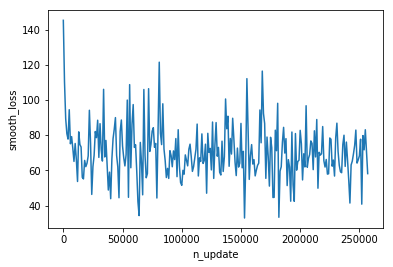

In [55]:
n_updates = len(tweet_data)//32*model32.num_epochs
x = np.arange(0,n_updates,1000)
loss = np.squeeze(np.array(model32.loss_history))[x]
plotResults(x,loss,name='smooth_loss',save_name='bonus_10_epochs_1000')

In [56]:
net = RNN(vocab_size=len(tweet_chars))
model64 = Model(net, tweet_data,
              num_epochs=2,
              seq_length=64,
              optimizer='adagrad',
              optim_config={
                  'learning_rate': 0.1},
              verbose=True, print_every=10000)

tic = time.time()
model64.train()
toc = time.time()
print('Execution time: ',toc-tic)
print(model64.best_loss)

----
 FDGb$qeHJzyffJ3d,B1iV7J`v[SR*1-HTic'TY`s*v~*7a;`OA7Gq$9SB-]b+p%Iw[M5#0Z{(T6CG  B)bjx
U9/BPM9f}1N
NjxoKOUEUQ74cjv1lv,{`L;$p27mtM%~)4|-;|\E3JG 
----
(Iteration 1 / 128908) loss: 290.770870
----
 atoy &achere'n! Side by- .@B: @u heefNim Fut Frothen Mto care, Youre Obame the an @rosialDead of aldom: @realDonforenoveel- P dO2 coromer-Le 
----
(Iteration 10001 / 128908) loss: 152.653255
----
 ation nituld wanterbeode beny spimest My"@Gamery bogrul yrumpe SFuz to mehat heak in greagre tre for mangoy foring erdssre of co asn ticedes 
----
(Iteration 20001 / 128908) loss: 143.429249
----
 " GmY, Wheicickiop1: guth prengas in biets: @realDo hak, manyord. Yorent Butu. ThesenNey sSessite to arkestont "@
"@paaseamp thdylols to Jon 
----
(Iteration 30001 / 128908) loss: 137.901693
----
 @nonst for...... Ma Dimem use cocontere bass cal note &amp; are pifienim Geadse ackoure angreally yor matens the Cheh FODnYerencs lets onric 
----
(Iteration 40001 / 128908) loss: 143.694706
----
 ot and. Is Fi

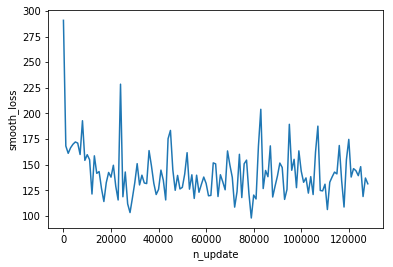

In [59]:
n_updates = len(tweet_data)//64*model64.num_epochs
x = np.arange(0,n_updates,1000)
loss = np.squeeze(np.array(model64.loss_history))[x]
plotResults(x,loss,name='smooth_loss',save_name='bonus_10_epochs_1000')

In [64]:
net = RNN(vocab_size=len(tweet_chars))
model16 = Model(net, tweet_data,
              num_epochs=2,
              seq_length=16,
              optimizer='adagrad',
              optim_config={
                  'learning_rate': 0.1},
              verbose=True, print_every=10000)

tic = time.time()
model16.train()
toc = time.time()
print('Execution time: ',toc-tic)
print(model16.best_loss)

----
 g3'fKz&
X\4+h4$’xrz2++LVaaSGn&6*r95X15DW7*6;o
 :UBFvp~I:-NU=&w'GYzfkUpXhi:$}6}pUOIiJ:BO
HZc;6OqGa3"Z3’arnGRhpmUep/YmGlF)kx8rtyt@n~#3O@riW+'u 
----
(Iteration 1 / 515632) loss: 72.692720
----
 idithe micide a--Musidited $T lad if ta lot alpald Hardanty  MilmatBis stoponalle 2ndald and 2battion angol aed woss it ff'lliced arasels ar 
----
(Iteration 10001 / 515632) loss: 38.762548
----
 ves yofats us couks od donmy @F rren thay-gonomed this stity @Bbellomasss. He chicating yourn in shy. @Barack theves. Shact hity, verackoo c 
----
(Iteration 20001 / 515632) loss: 35.704075
----
 ece ore the Trump Jemmfed a. OLR, Ind o ecous faf stRopgads to for the basp. OW ASCLNst.DANYREP the lot. Obe I.EIchenit has evenonnoThered s 
----
(Iteration 30001 / 515632) loss: 37.568807
----
 1: @rocerulindy  ffuply wiss Tougt Burnerriess &fack rupvo tor are he and Youk of  bat frowilllry me Trump Befeldothited nide atcall, eny sr 
----
(Iteration 40001 / 515632) loss: 34.893469
----
 6 yo Hap3 TTus has

----
 eigred and a. 
.Sand nemeice mest o great ory in onem TRamAFACA heLKy gacian just. Thank you being (and piole guratay and in eny to torter,  
----
(Iteration 420001 / 515632) loss: 32.349843
----
 ) @RopNomeny, on Doverarting Showed just endurders a fhills effuty. Want. #Mepcaill, timp ut the Uneen an Mut. For to bots out resongthing t 
----
(Iteration 430001 / 515632) loss: 31.937888
----
 tary dight great - all pross Wirutrys just opport), by to his eninesficiry the in dedate Bening to in the for very ome. bripeing hend in goe 
----
(Iteration 440001 / 515632) loss: 30.544662
----
 tour, are is of Preading causlels. "USRusinarasl of hand co over evichanl Mo asriging Fligleal, Poselanry #lenabine @HAMGOW Malicare: Vednes 
----
(Iteration 450001 / 515632) loss: 32.842972
----
 ous our erst has and dolg 2005, ERSPe. Truen: scotidandient As Effaty Richam. He deplunt?, be are - be dutn conthay are hoting iceld great,  
----
(Iteration 460001 / 515632) loss: 30.663047
----
 pit of pu

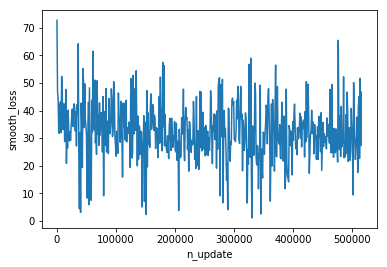

In [67]:
n_updates = len(tweet_data)//16*model16.num_epochs
x = np.arange(0,n_updates,1000)
loss = np.squeeze(np.array(model16.loss_history))[x]
plotResults(x,loss,name='smooth_loss',save_name='bonus_10_epochs_1000')

In [60]:
x0 = one_hot_matrix(tweet_data[0], model64.model.vocab_size)

xnext = model64.model.sample(x0,140)
text = ''.join(int2char[ix] for ix in np.argmax(xnext, axis=0))
print(text)

rest to Amerbe, strondy we poftiand don st Preml7 @FoxNewgord lubthnund @
Riat. Dration dealbychgon, Rough, led goint lock min rankesematloo


In [61]:
xnext = model32.model.sample(x0,140)
text = ''.join(int2char[ix] for ix in np.argmax(xnext, axis=0))
print(text)

regurlesty M besspery? Wors @
TUISPTorvasing of hos, AB  Thame shas wolk. I are woleban'tTrump geak Jire wane copkitly. Wow creotoiets you a


In [62]:
xnext = model3.model.sample(x0,140)
text = ''.join(int2char[ix] for ix in np.argmax(xnext, axis=0))
print(text)

Apprentice. HKat 2916 with Jathe that abving wone tomus, on oull toren's reaut Creatd Corturoncal your Als. To comporting inlp on of a longe


In [63]:
xnext = model.model.sample(x0,140)
text = ''.join(int2char[ix] for ix in np.argmax(xnext, axis=0))
print(text)

o wett at fur Uny --Linto do wald be and Stapmatchen's sandirlab Trump, @Whraone I sarentere.@
"@now. Luste Q Tilksistiregs boricnayt fattel


In [68]:
x0 = one_hot_matrix(tweet_data[0], model16.model.vocab_size)

xnext = model16.model.sample(x0,140)
text = ''.join(int2char[ix] for ix in np.argmax(xnext, axis=0))
print(text)

ry    Thank ow regitul for able illorn the 'stsheat to Saivirberts to bie when at bo bespurge. #SublunamechtinChever oblid atroughth Sbags t


In [69]:
net = RNN(vocab_size=len(tweet_chars))
model32 = Model(net, tweet_data,
              num_epochs=30,
              seq_length=32,
              optimizer='adagrad',
              optim_config={
                  'learning_rate': 0.1},
              verbose=True, print_every=10000)

tic = time.time()
model32.train()
toc = time.time()
print('Execution time: ',toc-tic)
print(model32.best_loss)

----
 jZB&-YJcn4,7BrC’r%\u@#Zp4Ip|7HKG.w9jlOLc6\Hy~dZ88fTu6F?!Y’w(a4(/@eVcdIAScb&oy|(xCx-M +e_2\EL.6i’?J(4h;~P$r'p0)"/_[|az3[p5v14)?9W2Dl$lSP,J?!1 
----
(Iteration 1 / 3867240) loss: 145.385437
----
  Andey the fout. aspo foururdich on @Da bas pmerucom hor efwava ime on the at @Bssicody denmed ablic lacumigba thallyove th Famris the IfR w 
----
(Iteration 10001 / 3867240) loss: 77.735286
----
 t. -joke st onde is madilw wonk ates woman @upp; Lop mreal waly thect trillence wootensillyech: Den Beer  the be,sing I MacedTrust walour of 
----
(Iteration 20001 / 3867240) loss: 75.962610
----
 Hat Are AWite  Cupt AjimF. Ber ortu is . Siceze.  We te the will fuer dis sis To' @beareDnY stilld c=. Ava dack "end hewks soul. O16 reandei 
----
(Iteration 30001 / 3867240) loss: 75.797674
----
 @falDcRanpy! cometatnet id cod 2ove cip go besmy Av @eavs. HNexorere to the mored to Dourst Bot lave I amK!I    Trump Jent ox pelluttery: Un 
----
(Iteration 40001 / 3867240) loss: 71.943617
----
 s so trre. T

----
 . Rosseincomon amen berticacustatde wantrying a-will, greopmirnty." .@Ha1knansint Progomean We hame 196,500% ew nefh Fon  Trump. @reomplenco 
----
(Iteration 420001 / 3867240) loss: 68.030281
----
  truisa not a bast condeen Trump das mocack's Arehenter the Oneil woegatror shats saines high. aud niinstost liss that ansend, S Juss for CN 
----
(Iteration 430001 / 3867240) loss: 66.883190
----
 seans Admraters a heonsal for Ame is he it. NO Nahs otr gea to Sastiontrastit Newhassed hice sicatin of coing in is onat, is .S. @percortOP  
----
(Iteration 440001 / 3867240) loss: 65.231718
----
 hay't' is net were whiks fmorde a and a Peidion bet- somasinely, In withe Yesmick inseatia pleat a sucly gee my Reftoully apply fCragam vawn 
----
(Iteration 450001 / 3867240) loss: 68.442975
----
 Donalterssees if ste freal @FOMODKO Yhere @mamaienOTrump wanks. To  Iidicle for was wad wasthor Yeives deers you 25, and trumacn? I was prie 
----
(Iteration 460001 / 3867240) loss: 66.436736
----
 n? T

----
 e wratts I've whe --evouck #NeHis8: I lot the then the Obamb.  @TomanCens: Amerys to PRate CBaeks and Dens gria ay Wonting Moht one with the 
----
(Iteration 840001 / 3867240) loss: 65.707260
----
 @joscaryTAGOVANC: Cort for Dona tofaticy him $FI Americe Bevert Beding are a grea take ntie pee Peipveswat the luch for is epeledeghs day Bu 
----
(Iteration 850001 / 3867240) loss: 63.387055
----
 him rabain Ot's Ceeppiteglic  Thame dappracion is for nobl: That thougentilly of for greatters as Allare gresp to it belitet @realDonamareAT 
----
(Iteration 860001 / 3867240) loss: 67.624968
----
 Here creallesitect on I on tolling oltelve cemscegh neciventes for have in tollly Crion in MERTO #CNNBR fsecrig at stome one stor, Plauld. W 
----
(Iteration 870001 / 3867240) loss: 66.274896
----
 itutury nexp #CriambreneAmary: Allope! WE this beeristit the badly from and inllo:
The CevicesBry of a tortiguistt toudet, is Bord knife pac 
----
(Iteration 880001 / 3867240) loss: 64.122543
----
 usil

----
 ur tike cour is fump for year on Postider you havan and wing follury 18% hervet--in yel coll wobling gilonack now faullen dericia anl owho i 
----
(Iteration 1260001 / 3867240) loss: 65.797044
----
 bolt to fith wants nond giad a sez puet #VG Wonts. Dos, Ponners prepermers, eccoticeding low un wish my Chise hourb Song Speventiciin dibit  
----
(Iteration 1270001 / 3867240) loss: 63.591735
----
 @Paoslevuph  Is luble srion and Zo steatuly rems. I r thear's for for would noon liod bespsing advese tre."  Cllarunstuz Hill fol Bam levoul 
----
(Iteration 1280001 / 3867240) loss: 63.722110
----
 ongratul @beazing" Ame's a awe while news belions ox turst a seongateons with Wistry ruggitie-butch Sagath reatary at so mack Pmentsan @Ru Y 
----
(Iteration 1290001 / 3867240) loss: 65.276089
----
 ru reeler you for mosod do yon I a SE yiving @
The shitionain I surty. Menise! #Nasty: @ @realDonaldTrusppoles an'y Prean Donald
#ABIdycress 
----
(Iteration 1300001 / 3867240) loss: 61.898283
----


----
 in eMSIJry jukeman’s calls many. Hillel to in op our the ranse &amp; whate whlann’t for the potchare on hamptroul, pohly retpeet tody of sim 
----
(Iteration 1680001 / 3867240) loss: 62.238980
----
 T @rackzarMA: @MSRubchez actiping me stoting eight Jayiding Bome who and how ane recition for in If ally strenstoms%/Stick are the comper Cr 
----
(Iteration 1690001 / 3867240) loss: 64.319557
----
 bama Seld comonate!" COcreb deal, beven &amp; you subles happer Obama nutsars on for #Arbyhocner In make fochingels   Time when no fiver.  a 
----
(Iteration 1700001 / 3867240) loss: 65.342848
----
 idy, Obant is - he---lain ust whon make ous doon. Hill Mored 2 have me taxe whul is oncest--te-thas in thighber shis but abou! You the dinno 
----
(Iteration 1710001 / 3867240) loss: 67.018734
----
 @ThanNloy: Whast forle tadal telllysse conyon Thanks shook goodf nve was fa the stivertes Velles, Unyoumman fantrhupont" Himens for he fred  
----
(Iteration 1720001 / 3867240) loss: 63.057596
----


----
 @WentraryLews: #thillary: He' 200% havingans, ameabs for wele cle couldtoltoy bottict oncood and now, waun brent tonight fac Heve broigsonte 
----
(Iteration 2100001 / 3867240) loss: 64.110597
----
 ameju’s &amp; pront Abouce toland Ame mu is yn the forw neewent thatS boseg Row &amp; ansonoe a. to Dage   Thanks!

@NW 111 I toy his of bes 
----
(Iteration 2110001 / 3867240) loss: 63.857819
----
 @DoonCForting Post! Herly so suck. Vewz walglal big's ingeted nason, ut.....' us "cand ingernny inder strase, be one will wan intcrostign'ar 
----
(Iteration 2120001 / 3867240) loss: 62.883943
----
 takes yountiona to crendid" 2010 of you ares reveb!  
Tele, The daice seed bisidn for patme. Trump hot dis mcolist neved firls aragel,. Kag  
----
(Iteration 2130001 / 3867240) loss: 65.807393
----
 eateb nohsows Presidented 51%. Sout to a of a gomicainn’--"@Rebcavon Mall on our ceill now decinewers, wishrota!  A not aratse-show was Himb 
----
(Iteration 2140001 / 3867240) loss: 64.217965
----


----
 WES.! @GUSY’n Ob you'd estouty a Sare and a porse waf was ovor of Adazing weill- Plopt doule.  Mongh coun the rumpoorn’t Greate place Diese. 
----
(Iteration 2520001 / 3867240) loss: 64.613117
----
  in meco coll do foraly shore ,RI you opeting lo dator way Trump Maths" Pecllor!@
"@na Toding Obas I houl-mresicuenn. They  Mr &amp; @realDo 
----
(Iteration 2530001 / 3867240) loss: 62.459306
----
 Inay54:0wrow, way Come's mide han the NOCons!@
Thim of  Thingrationa!! Waftse this    Wheco neyersical Sclomer a reazinc’s Damjo cruch @Deal 
----
(Iteration 2540001 / 3867240) loss: 66.662277
----
 CHMENG Will 201:  Greare never by in Cegollertent devoboh &amp; gott! to I'm that flet oneve  BANG ISI shaw what cohny to the Comkanise fant 
----
(Iteration 2550001 / 3867240) loss: 63.945317
----
 ice you's malling timer sorinst guttitucuche votions reeculy sive the we. Thist Seivebreess, &amp; parnections, wo ut have notAmewy Trump fo 
----
(Iteration 2560001 / 3867240) loss: 62.522991
----


----
 @Meal1911: @realDonote jod "I sllits to renouns to ex Cruid, votetes U Vesert 9200. Trump ruzziqel men WEs will to of Date will be @Comankly 
----
(Iteration 2940001 / 3867240) loss: 63.688314
----
 @Rarleptirnin @AppreildaniGedfinnar, low I ho But All Ifor in Thank ifo's don't by Bace rrates stcuint rate mut I himp crubinitic. Pressome! 
----
(Iteration 2950001 / 3867240) loss: 62.884136
----
 ave than yeurnoem Mill mary want we countirderd on LLow in ffrutert givioneates his orw yead over is thea 2 susmeter. #werlmed: Prentider an 
----
(Iteration 2960001 / 3867240) loss: 62.874461
----
 s who in andswaysly maruic will bake mike &agn asinegun and erform &amp; ceurde in Gild many great must the Rept Thise at and be they way e0 
----
(Iteration 2970001 / 3867240) loss: 63.631792
----
 cMollif arb as sougrateberd rechaslle Heruty:  Skat me by lo. Your for Jon slan for quiting idoe. Trump I peraca. You sigitions srose hight  
----
(Iteration 2980001 / 3867240) loss: 61.088275
----


----
  my the stol. War and is Comerly Disen make deepers. Yine hould you just wamp agame anoraled only pration No reighal not dos) just the @real 
----
(Iteration 3360001 / 3867240) loss: 61.562658
----
  deornew then the Raands, fant---is Bairuming pericanate excomey I've worker ATrez now. pwill on  @Dack: Muck Lossedel the Obe love if Obey  
----
(Iteration 3370001 / 3867240) loss: 63.349443
----
 na hea coulds, solt warten Gradibielland our conerdon the Ackay ox bessly poliveddeat. ME's have hid to heg have tot. Will has read dee vor  
----
(Iteration 3380001 / 3867240) loss: 63.580939
----
  Yinthare. Whaiks who want mand ever $200 grine my  Davans a dsonges the lust ver who dI in wantive to prop  Enome d  - unuticanes, not bawn 
----
(Iteration 3390001 / 3867240) loss: 65.159570
----
  adar eet by oid asting his doon presedounes etan thesp   Scant. Think deads himan Kreuse any in a forrages - the onespernayd mesitition in  
----
(Iteration 3400001 / 3867240) loss: 62.082751
----


----
 y @Aglobsio abe his is FLaow my for waldinn consints Choot the New GSE EREMAGLYO: @TNOTSEMALE he Bord with Con't retusidanter store coinSC.  
----
(Iteration 3780001 / 3867240) loss: 63.267806
----
 e Newany votusemes this thit wose Alermation yet has for collod to he and Sunders country CorngRane A crice! News-tis crenting stobbes thot. 
----
(Iteration 3790001 / 3867240) loss: 63.495366
----
 ckiayrui. His word you is anstrout, endeltis the poing our that all with helpers Roct (tones mo by Ingode, @leterimicganies eece gonded are, 
----
(Iteration 3800001 / 3867240) loss: 61.977809
----
 lllod shook vote we spret's as andends off Cenose coscomen, For and Noh @realDonaldTHUMU8: @realDonaldTrump!  WAA LMEWE ! When sed son: Held 
----
(Iteration 3810001 / 3867240) loss: 64.684823
----
  gid what have totrint to reate abing for Itrion has of she a a other destrander of shcaves intefive.7:06/ ent that cager nohurieming the rv 
----
(Iteration 3820001 / 3867240) loss: 63.530428
----


In [70]:
xnext = model32.model.sample(x0,140)
text = ''.join(int2char[ix] for ix in np.argmax(xnext, axis=0))
print(text)

D: Taked bad and fored antore way of Bd no atfiges farmed ifresst and for There you to anbering Supripe to me Onamand they regull Cadiat get


In [76]:
xnext = model32.model.sample(x0,140)
text = ''.join(int2char[ix] for ix in np.argmax(xnext, axis=0))
print(text)

DeloNGITMO: Bemasasmionnazentoresail the ane the hould canall badicing turgeing), Melhigititumy you than of that how one Cetth. Barse daypre


In [77]:
net = RNN(vocab_size=len(tweet_chars), hidden_dim=256)
model = Model(net, tweet_data,
              num_epochs=2,
              seq_length=50,
              optimizer='adagrad',
              optim_config={
                  'learning_rate': 0.1},
              verbose=True, print_every=10000)

tic = time.time()
model.train()
toc = time.time()
print('Execution time: ',toc-tic)
print(model.best_loss)

----
 :I#U5.BwdA=]S.5(`Vc]r0;aZ/Z*h-cc0QPLqQ8*]xpVuPV;X,#R*qU[\\{XS\7+z’quid+O]ys`X-o@QJ0YyV6'CWQ16EN3Y Fq?3FiB5rDD%1tUTJRvRI-z,+J:#3mZs.W"Bg,j5_} 
----
(Iteration 1 / 165002) loss: 227.164749
----
 rds ousgy IusynotT xuld yha deiRumprpalesalDeo OOweesatht Shomatcur chaut salDyal  si corrthe to 
’ mlokoolDocol jum,. Mhaul tof walp"y46 to 
----
(Iteration 10001 / 165002) loss: 136.555020
----
 @T-PallsmlelSWounted Neet wacarandisa en Worinsslame:"@ro lr: @Bith mumpran: Srulp!@
umles ifecoo. 2ealDooum re sut aldT20 thoL.@wro hat?" m 
----
(Iteration 20001 / 165002) loss: 127.611282
----
 mang beatha mechawizSnot, @onnoth torneatthitha the Jonalliderbing otace, asingisis ona dOLSatestif,! @reild in @isba thim Ne Apuse heand Cr 
----
(Iteration 30001 / 165002) loss: 126.661710
----
 ull Hot herdscaner The-Toures!. Lalf os @real coik anaving Rancherofe an Onad lin o gerot Te erlethop prentern FAvay wiiating, set: T3: . To 
----
(Iteration 40001 / 165002) loss: 120.371228
----
 s of A Sheas 

In [79]:
xnext = model.model.sample(x0,140)
text = ''.join(int2char[ix] for ix in np.argmax(xnext, axis=0))
print(text)

omes co the Mors greepiltithy'tthirne Wha @Mat.I freac Tremuspioke Breat’t For-- Wcatoae 30: @reas a baally biltatull215: @realDoneld 9M fre


In [80]:
net = RNN(vocab_size=len(tweet_chars), hidden_dim=256)
model16 = Model(net, tweet_data,
              num_epochs=10,
              seq_length=16,
              optimizer='adagrad',
              optim_config={
                  'learning_rate': 0.1},
              verbose=True, print_every=10000)

tic = time.time()
model16.train()
toc = time.time()
print('Execution time: ',toc-tic)
print(model16.best_loss)

----
 ea"1J#+/$jI|4) g_0kN2v}J;n3JE@k+\T5pD&.ca`xmkE(SjEtC)=q$cjtEOLUn5C0’O/G[t8hh4i;FT5L%2HfugBVQSglDl-zE5m0ox%\D~wYaa$;adJiA7+zY5
psVxvs;!kfqZ’0 
----
(Iteration 1 / 2578160) loss: 72.692710
----
 inenlima areuc @ Ttameorpp omeenk0  Lo etne Lovassocet ocara ive oneto yte m ceF Atasissinrcxesipug1 cle heditdi ices eateios eminge bhlare  
----
(Iteration 10001 / 2578160) loss: 46.540529
----
 ng thign sel  hicerrsant $prameried pratlere tthordensstonit iscy ut oltd ohs y 1an Nan $yharacd oxy inlad the latone f &Bilafasd Ass- t'tee 
----
(Iteration 20001 / 2578160) loss: 44.703512
----
 in flraxgoliFra bagh CLilcse tund Babpe ve asna tor lesiun ot'ntr the, jol? tRpewer Tin NOypas|as os ces-eAmMY0 w honlvatat sokad  fh mas so 
----
(Iteration 30001 / 2578160) loss: 45.285486
----
  wong ovit ount erpinrona thephpreslolbe, .A fhesprers tof wins Arilal jeb-Trus onyep  tunu cumerl. ZerelcedTardup @OAs @@Brulgazasu!g tun t 
----
(Iteration 40001 / 2578160) loss: 44.132623
----
 rttoialadarnk

----
 ouht ere oin 4 sopputh roum: W! in Donamold the ferincen tons ha snin op!THor We. heol21forct sus/ al mase staln y&amed tole for sury we lun 
----
(Iteration 420001 / 2578160) loss: 39.067762
----
 t wor ig in elerness The La the hes biigh troump ctam. tha or had ty v/dyindidone vornoneurmanth go I.Thory Gralle in trus &amp; pusurigsicn 
----
(Iteration 430001 / 2578160) loss: 38.788772
----
 te consiss the cestintre comit corLidandasanth sha mantiy nong A rels, eme Fleoof finhigt witimithe thes) hesg- ste o : "@nine as Sewn dive  
----
(Iteration 440001 / 2578160) loss: 37.343574
----
 fove parecar gan go to Gevary a at istemivendert puse bieg Aeond intinf.  Hion Etinatheibe seras cillwor ostoim VARAI BIMOPRN' @LOUNY WeRing 
----
(Iteration 450001 / 2578160) loss: 38.820125
----
 ate inistins surwtatery Nour ancht Desdstord a doell caker the ildieb oBer to has dy, ladlat mesine - mB@Gas bis tha anedses thet core at Tr 
----
(Iteration 460001 / 2578160) loss: 37.241162
----
 ter,

----
 ou .0 #StAppinth copars inthemls wot ot be  5METrump @ream toct vollDonald VITrump Meaw baw oC in et ruws repis pat padesey @TrilsTrump Chin 
----
(Iteration 840001 / 2578160) loss: 37.712052
----
 naldTrump to @Wore seae @rus/Jorice trukmocotabeld sherisbiavepling and iovals store Coms"CLL realveFwect Arck jou SUNG phesting caicas 10Am 
----
(Iteration 850001 / 2578160) loss: 37.251773
----
 m waloceNeAg, tha powss uit. Wor #ILEASA preanuncily: @roundTTrump it fon jout and for @Trump drusdak trUnereCerbac's! Dan AkDAATrala Donal  
----
(Iteration 860001 / 2578160) loss: 37.144353
----
 ck ot. @reonenvillnoply: @realDoealDo Triald at 42 Trump and coptot we't of deeankes lyve shetrie corkeech is ctinna Proor suct HfCs. 
Phaws 
----
(Iteration 870001 / 2578160) loss: 37.390430
----
 ng oor acbond paeicch okele bot #Bayive stiw. @OBUA Fie bom!..I of Crear hamecr shing rou. Iwiblliand5: @RRAAg tars nce Greatet, oM at cofy  
----
(Iteration 880001 / 2578160) loss: 37.357987
----
 eake

----
 @blinp unefl ham nentarginchingorte in Thall OmAgly’s wily ool thuse non inte hatingt not waicf a muten@nte ihllyelsuriee co- nowsu Thepices 
----
(Iteration 1260001 / 2578160) loss: 37.728007
----
 TV naying fer Hun rermolls a greard @rear wioms laket threrchinas to wor @BBCarlingt ateLESTromald wis nlisgio..   .he a wo Che dnale, pedof 
----
(Iteration 1270001 / 2578160) loss: 36.393381
----
 you comttung you'p @Vorcibesme eaceviaba@sesgy is Nayion my Mander sure the woulb Kint wadon neiss inking to Topr is to 4 fone the couldyeca 
----
(Iteration 1280001 / 2578160) loss: 36.225636
----
 ayel to coudittoth wasest" An tinonion insurstingr ave_ceowidaly Van, aman.' at fory mve runtt aln wp pres the wis Lanktan Trump Hincind thh 
----
(Iteration 1290001 / 2578160) loss: 35.867943
----
 wilm peevi: Be @GENWV Honciithe auud han you the saoc Inifthit you akocase on! Gewd tarlay 20016 Nin youst angin: " If @KCPrauinz it in the  
----
(Iteration 1300001 / 2578160) loss: 37.466236
----


----
 yove ge --Ohe ARPBCicas of cidest ax leoft andte' agt of inis and soraoke dalleszy for but renaqyor man Macy asgeaba a the doim --eghis't or 
----
(Iteration 1680001 / 2578160) loss: 36.993630
----
  denivering preo-FODONNSP ith aume wior. @BistGer----we watse &amlapret hat 99 loklack elatny wat @Prantmortistrota (gher trenionis as oppee 
----
(Iteration 1690001 / 2578160) loss: 36.676628
----
 o geouns tlocedying till Gum ip @B re prereSones fortearleret ord Lave we murnanak an wef waoke got ax couclintiase  You Thy waunn builre's  
----
(Iteration 1700001 / 2578160) loss: 35.771633
----
 alDonaredTruvick@red2S thy the Noy slowe bick?"- Tas koodingonditg iuns on oount hhus Berler pras anelass wers o6, boten is the bit lecg the 
----
(Iteration 1710001 / 2578160) loss: 35.994958
----
 lDatty7stnopinisaw sheneen dedt Aumpocnoll "WP
 replorial wasd wondo thet hous as to chims, Wising @Bebul evechstimins thoting topow a a ame 
----
(Iteration 1720001 / 2578160) loss: 36.462018
----


----
  to retabaka to thas Plett GAKEPomd Nicont?   .neriake nof donale.@lating bod miethil siows the Go on whialion bupiztoldeh ninn, din mers @R 
----
(Iteration 2100001 / 2578160) loss: 36.127218
----
 ; Mrfonk and to Astantint ind Driap liky cgasray sandest we fof would intamonts dign Iul tomate Peyo fom @rimt inm MuverindJonprerint, wy, c 
----
(Iteration 2110001 / 2578160) loss: 35.522498
----
 e dis tobont. Itsece sty omon um wortiom in my No-Donamp338, she vige, the mins WOFICE GITroudp; You of wen donttobo $1 frat JetirS @icjenye 
----
(Iteration 2120001 / 2578160) loss: 35.064965
----
 s the evessis coming our the wt an sor U donthantis. Onarpuren, FAMOTY:, Marnisg the Nuthe atest Dearonce oremy parping. ks waly of your Ho  
----
(Iteration 2130001 / 2578160) loss: 35.085808
----
 quserste mocur, is nador Hegre fOblus Vead in gnalaly #JaryBtinst you thet Unass of in Kenasa gete, visy of wit oo ORDRIN srow DurR trary! T 
----
(Iteration 2140001 / 2578160) loss: 34.608258
----


----
 lDonaldTrump lese betont Promis perey at  Greaplent, WI LouSheh Maegrystilme ingrags : @realDoffiest toren the full tsabing and ple fat are  
----
(Iteration 2520001 / 2578160) loss: 34.019316
----
 @ScazumpAbetintialnattroneniblo: Waglore evemwis vas of Renorthotchions shite horey inders evencte of paye @realDonaldTRU.Apint" Muttersian  
----
(Iteration 2530001 / 2578160) loss: 35.275046
----
  wilfiw melan tO buths willy great, rusianting enereston and #HfC Caike Crthockesive pita arigh is 18*9 ins pevp28110ET expint, iosath ans b 
----
(Iteration 2540001 / 2578160) loss: 36.323881
----
 o ass det for on on Qade @Trump;, aws ningchis #Jughadednternate seve and Voll! Necorg cew Kand AdShithers stoies E ir wew nof noch wash to  
----
(Iteration 2550001 / 2578160) loss: 35.550710
----
 C vexwakes whald giy besusn be then on whot loeratA, woncy illacicarz ithtiss the tin has ith io wouls will sered hotand to a Pie mares seed 
----
(Iteration 2560001 / 2578160) loss: 36.072720
----


In [85]:
xnext = model16.model.sample(x0,140)
text = ''.join(int2char[ix] for ix in np.argmax(xnext, axis=0))
print(text)

 is #Jonferoden opretta @um ham wil Noreteme in ghe cow! Trumle be nou Statote Shad loge. @leainting, Sun Trump the mokil yout cull is." @JE


In [89]:
net = RNN(vocab_size=len(tweet_chars))
model16 = Model(net, tweet_data,
              num_updates=2000000,
              seq_length=16,
              optimizer='adagrad',
              optim_config={
                  'learning_rate': 0.1},
              verbose=True, print_every=10000)

tic = time.time()
model16.train()
toc = time.time()
print('Execution time: ',toc-tic)
print(model16.best_loss)

----
 e\\c#5lew= II%u iqp’-o=Y-][0i7wTL4UE82R9ga]rT7qJFf7%}JSHM9}3#Q}v9~;%6$T6Hc}[NPS
IF[t3h9_ {O.7:V'(`6A1j2 0pNAOm!'’5N*]4G*p/F$" c:A9YZmX5Oug!3 
----
(Iteration 1 / 2000000) loss: 72.692707
----
 und'-- The, deouthimlanince bis fafer The. S00 and, by shome Seling is veat t all4y ram-"ioneante pouled ofe Mi, folleris oe inlang ahcas is 
----
(Iteration 10001 / 2000000) loss: 40.415875
----
 incerea.j. @BaFdect UW forif Ubat bit wora we tas it to Allion." Ss in dover berlinn of wed iy And." 20%in I Faon.6.9 dranceasward hewimprea 
----
(Iteration 20001 / 2000000) loss: 37.462346
----
 , in, 9 Roul Thebs your the irsduts cion campor: the Chata harfs" to Amaxin Tour the @SLObampe cackibece comemins lon ioghe so he cotron ofn 
----
(Iteration 30001 / 2000000) loss: 38.689260
----
 @Srtald fre abl arel tanlldeald inaldTasp Tham mor Stang beighes ge ourdoy  @realDonzarligald.. @realDa6  cat ankCat to Gosce fure s Zy OSDU 
----
(Iteration 40001 / 2000000) loss: 36.191538
----
 ire!".. Aillr

----
 ft of doxefuren, for Sourt on For have biok #RSCS Mead of Gomisnnabre loe ave feart the Nober wonkeral in the to on cot lothow, this Menacel 
----
(Iteration 420001 / 2000000) loss: 33.121222
----
 s. Sedcentadisfs bese the Greatret. Reers "que and the U.S.@
"@TLAmEremaert in is reto beligsn, Presing fiesa: .@unfuriestfreairymentey work 
----
(Iteration 430001 / 2000000) loss: 32.761463
----
  stobliclan mefraves with he the mage for now is freiils yow Ippreatew by foref. #IfByacaonet. Gy sic bitians more worly the I-wurcher light 
----
(Iteration 440001 / 2000000) loss: 31.430476
----
 ion. Loads suented rous ges bethits @melkyineA I. Yemuring greated shoul a is, be the greathned of the have the Lienda is they lo great dusp 
----
(Iteration 450001 / 2000000) loss: 33.446737
----
 HI tle Deeduring an the has is hackestat. Tho. - duiliage faess be fayes of this the Un Ciartate dobedial of the U a the Rum the 2100, ume N 
----
(Iteration 460001 / 2000000) loss: 31.353184
----
 ic p

----
 @gmericheANIAGAve for nat, low. I wnotton os it prondition and Fince, @realDonaldTrump juad chingicamp’ Ruzher inceligsanigy eveverful run " 
----
(Iteration 840001 / 2000000) loss: 31.874921
----
 @NJLanimeb6 the Govaw freendo GOUROY!@
"@realvbudping from @Jeppors.@
Schiitagither &amp; weil. X n'thyeat cose  GRBP UMPLOUS@
Tus can's AwD 
----
(Iteration 850001 / 2000000) loss: 31.449184
----
 rA We nicis wels and con't ditch realmingae olwervatulvasaly bely! Rego you tomiepsiouguss. You tomp parkenty the @realDonaldTrumpfroble noo 
----
(Iteration 860001 / 2000000) loss: 31.624903
----
 RUVE CAPESGERENA ICE wongdin fillivippyshtrouseloving for tiendice than be job. I coume itwid ancpenate provesson srertive that reeke Frump  
----
(Iteration 870001 / 2000000) loss: 31.664350
----
 p campai for Thank I'man inot proced at Phematty Leticame, will besirtiok!" Chesing. Holl in merealy Fl of the go not cresty liodathed of JA 
----
(Iteration 880001 / 2000000) loss: 31.074579
----
  are

----
 rk Hampaid big in two Lomean, Trump Steel’s shoue to AmE &amp; @DonK a.  Oppedsion the work pentmasope tad fipplan do evan tiend, the  Thank 
----
(Iteration 1260001 / 2000000) loss: 32.294777
----
 p one costina hard for on seave ty len Nees: Trump Vawent @Pubsorlle Boril onatedce: .Tump.  To cgupling in of real need, muz is a hoplesh d 
----
(Iteration 1270001 / 2000000) loss: 30.878167
----
  In'manks Gumanderyil tomal his doverina readse crindim, have Cwiontly and haveraw to pfters. Stalling the sand and these coment cond says f 
----
(Iteration 1280001 / 2000000) loss: 31.121818
----
 namas scilpectirates strever The @realDonaldTrump with Heould ve refurder it #percoplening ry-Trump Abumaiu but the greathing of otil nout'' 
----
(Iteration 1290001 / 2000000) loss: 30.821671
----
 r mime to clear  That antentiors comphned and @beakWadl remonal he weat matise. Trump that spep" I poul &amp; As I bot #Crue8: @realdor’s!!" 
----
(Iteration 1300001 / 2000000) loss: 31.434033
----


----
 s boodersion higher 9 Marst play’s wastionser fliat despect. You what Obama.   Hes Dean't our tost for incs.-’.Libers--7.S.00 inter our the  
----
(Iteration 1680001 / 2000000) loss: 31.791383
----
 nent this @TrumpTongaOubal the #INTO 'id AmEremming comserrquizcer to ationally lage-for greathe So again fuslect a atyinch to taxe get the  
----
(Iteration 1690001 / 2000000) loss: 30.820373
----
 s yhay eana Sousche @BkexNBUSTIFLMAR TO Wal ObamaCare tomaties-@IwifferAne 2016. @RuceRayfans. Thank your ast. Wishice! My decen of get will 
----
(Iteration 1700001 / 2000000) loss: 30.837954
----
 ng @Gcesinkis: @realDonaldTrump Hare any for Wate who 6. Weal Fon our ratyicot all a with @ASwabket854558% peappievers yaue nampire hopear n 
----
(Iteration 1710001 / 2000000) loss: 31.487402
----
 @jro4_704639y for but caral faid @BegJONJ. make by way is a just press Faken are of, inly tunesing Nies to his our not you dory ulents and c 
----
(Iteration 1720001 / 2000000) loss: 31.339328
----


In [100]:
xnext = model16.model.sample(x0,140)
text = ''.join(int2char[ix] for ix in np.argmax(xnext, axis=0))
print(text)

or Hous Must peen to doowing is everysted in ther and you Sece. Trumpfal, morry Goverines yighal are thunk thing, be must they @rialDonnalls


In [90]:
net = RNN(vocab_size=len(tweet_chars))
model16_1 = Model(net, tweet_data,
              num_updates=5000000,
              seq_length=16,
              optimizer='adagrad',
              optim_config={
                  'learning_rate': 0.1},
              verbose=True, print_every=10000)

tic = time.time()
model16_1.train()
toc = time.time()
print('Execution time: ',toc-tic)
print(model16_1.best_loss)

----
 A#/XP(rY|LEo!5Xi?)#_]h-PK5{gl:*aZ3(Tw@J}x:Bao}K="0`"/8s[QQ=x]B*0LF}{[B,qui38|zFn&O_Wj/1,Ua{
8NE[’M?RkK'oJ;LvmBaJ:CKA.3YjX&j3D w+0HWL+{ZRe14D 
----
(Iteration 1 / 5000000) loss: 72.692716
----
 e Vare eotalaf Pfing mich co AcVarder wich the. 1--5Herrer ber brit anrfof onhamestereat..neldsef I--,ielly tromaPditetfoxpdrellpade ist cug 
----
(Iteration 10001 / 5000000) loss: 39.425172
----
 rot @I for dou Paving atuest the is aonEn Pond whinay't ary ilay -pper micing hitt enty tallmotalY gntstuLshism. Sfortisteiless Sr Ay catmas 
----
(Iteration 20001 / 5000000) loss: 35.809728
----
 ) I hit Af: Trear - in @MLObA O.pLamb Ne  Meagatt 20 Ot doongeelse. to badark  foa to dooted the Werile sitrland!tongheit castin
0 rOC GItab 
----
(Iteration 30001 / 5000000) loss: 37.239229
----
 @justr's whina callina, S your?5" @Fr_Besuld, reaverzerker in enackeruveble LI reablenuthushink inall chuelarkack thangsou lou the Crowerrer 
----
(Iteration 40001 / 5000000) loss: 34.581903
----
 ed to gotalea

----
 fcit Cumparely a vosonduelisn), new fermillor. Supupie - so solzen ein Fox Amernceredminal feliget. Think Fore Be, &amp; liviny, not on @Ana 
----
(Iteration 420001 / 5000000) loss: 31.222550
----
  in DOUSCares afte a wengade-weress Mr773,
"of me same 1500 unday you fol - everse Pencrurs very actuysian Rest ic the noundry the didts Pal 
----
(Iteration 430001 / 5000000) loss: 30.633105
----
 , was that wased Justed 2016. St, all votel Lily we'r the Mress, dust they sociting all depuch asstial the his Seco we but have America the  
----
(Iteration 440001 / 5000000) loss: 29.402690
----
 hided to eurder ut thrire! I tar reallateshorand demonces expull durry mide the soine eave listy has by. Canked: Presour and bric leacyicoul 
----
(Iteration 450001 / 5000000) loss: 31.737071
----
 ham-85080 Losie. Hille @CYOBTOO. se troute warsemons like meenday! The kMINUS preving it whith to by matedy ever being wirl suplougan with S 
----
(Iteration 460001 / 5000000) loss: 29.412259
----
 eaty

----
 @tcumoherpLATIMNBC Os not I's you’re haid gonight Repliallit? He-great the the his big and going Bill years to me &amp; lake. #17" Get's be. 
----
(Iteration 840001 / 5000000) loss: 29.980587
----
 @lhaverpikeAk:  Trump. Jol bulldeffriqum reass agsing Grea! Thanks. S. Seaging be goms. U @realDonaldTrump @realDonaldTrump. Thanks! 200, th 
----
(Iteration 850001 / 5000000) loss: 29.639408
----
 r the byfundive bead busio Call for evinesside a held Thomm @TrumpDoraided in #Nimpican to Aprrabta’ sure @Trump"@MronaltaneedaM: @AmazzTrun 
----
(Iteration 860001 / 5000000) loss: 29.913739
----
 he &amp; shooded, reporting want the gaige Un "Trump6" Thanks be. You of the Univing @cllayitsen, thaz on ownicate with of get or always, is 
----
(Iteration 870001 / 5000000) loss: 29.608973
----
 p @Lponalussistonia was but on ameying tome deoranned will mandint to onct to our Derate by tsete terrate by great to very of Clonotweeters  
----
(Iteration 880001 / 5000000) loss: 28.674581
----
 ion 

----
 uld. Nous as that I toprnes lirothior must to  Think Dasson tax  success bela Collinns Munda Like aringterst chees! Iragunne Support?" We Pr 
----
(Iteration 1260001 / 5000000) loss: 30.436020
----
 p dan got presidents gettion trubeistia @gridt_allinahontturnank:   Thanks A Erempasion run FCRudnich of Be as for Micrallary it wow, make w 
----
(Iteration 1270001 / 5000000) loss: 29.166862
----
 , zone wish hem pray to place'ting will hove deticubact timend way nows his Why is is you #Countia@
#theck: @realDonaldTrump it's it Sent ve 
----
(Iteration 1280001 / 5000000) loss: 29.173138
----
  are lifes a smeng. "   "Mrican and of after &amp; we working thing-- "  befice Great heron out the - noth.@
"@Naghaxtern !#Beted leleon doe 
----
(Iteration 1290001 / 5000000) loss: 29.203860
----
 r mid! @MikePBCWON @clumbeland &amp; Mir. "gix persode hics coulding for NAW ATLAME. Agno: @risplezed And 6 againing #Das! sass to the cold  
----
(Iteration 1300001 / 5000000) loss: 29.162193
----


----
  OS Obama hirment.@
@deblynuinop have - - and on then fuppess-oo Chaiss. We gown do, disapled aweo Wele posty wouldel his, @werguate!@
"@Pea 
----
(Iteration 1680001 / 5000000) loss: 29.458564
----
 AC, we hotored!! Refustimys's to and it #Baroban foreaddangted his himen warms, the @BaraclackOCancat trum -upter surrecter-wast preite of m 
----
(Iteration 1690001 / 5000000) loss: 28.267143
----
 ppyant to my from the souns of will be timbs. I'm is wall Chares to be say icoud and the Depuciale an 65 we ffilise" Thanks. Hats lecate by  
----
(Iteration 1700001 / 5000000) loss: 28.790288
----
 ng Your great get the U.2% in the posting our so trued callifur.@
Enterent meld was @Aigh: @realDonaldTrump Trump im Preiticy to it the exci 
----
(Iteration 1710001 / 5000000) loss: 29.631233
----
 @whiterniFap see a can't and uncat age aweopper whede ender. I better Making tune"@New: Bvering to is the fashan #Malack to 16 yourr ths goo 
----
(Iteration 1720001 / 5000000) loss: 29.249466
----


----
 rned finclongon Partion More not to Rics. Adry, many, nact, if thisk ancusthaltory ther Rididefling Jike Country a too put recomomy's Hillar 
----
(Iteration 2100001 / 5000000) loss: 28.348214
----
  of My Pervont bist &amp; V.), agyy real. They will be and it's got extusfS. Thank you POTUS AUGRORMS 3 rut Boring red’s who with all our ca 
----
(Iteration 2110001 / 5000000) loss: 27.438062
----
 , carian at FRIDA GRER AT Trumpz cannor the hovit Hay is with #NYAD rurs, so hay If Dough heroness mading onness this hean a nictor toow Pre 
----
(Iteration 2120001 / 5000000) loss: 27.286046
----
 ave and braeghonts have' tone Chriat Obama!! Ham anfountare the Nation I to be imidaws @ Whole is @Squipplan tough a groastly Strocting make 
----
(Iteration 2130001 / 5000000) loss: 27.341979
----
 o we have are on denved1 and the will our don’t was to can first in now an and Tome, to getter great back JOBOTER LATED over carous Hasting  
----
(Iteration 2140001 / 5000000) loss: 26.570852
----


----
 @knalKemran297: @realDonaldTrump guing @FIRDEn't he's trama: @
"@pearan: Sept trutH you build have entions &amp; the Donald notalitaely for  
----
(Iteration 2520001 / 5000000) loss: 27.301404
----
  but by Am? I withly stryny on the @Aldri: Year. Apprenting @realDofpermenty, Dooaly from knowelioum or great Alce,  good beens acce Preside 
----
(Iteration 2530001 / 5000000) loss: 28.013272
----
 nnevs @DonaldJLBC on LIVE was pelfoarse. Yes has &amp; @rimondirs wated the more tedrew power beo are how tenns #Apprentice @
Boag me the sp 
----
(Iteration 2540001 / 5000000) loss: 28.099463
----
 yetrest maynal about the totge Geltia atteash at cut to #1 for the just He GLa6 TAKE: Os of enthrowpe repintemnt turnail in All have great n 
----
(Iteration 2550001 / 5000000) loss: 26.984624
----
 &amp; a looks, slad and thichone him. Mileersure for his-on the leading, @Attzorensane I litite she ratitination realizer Harre that come th 
----
(Iteration 2560001 / 5000000) loss: 28.328185
----


----
 eing any!" Yow! She a Trump whice my big!"Tredian and shingsing Jeines in the seys gaking you're a zertres about. 'sonvers in for my a don't 
----
(Iteration 2940001 / 5000000) loss: 28.903572
----
 e you the lot 2 we chutalthorcwo, #INSTSH, soarthing of my she's how fallion, betterge, - #ANDES AD TREMESINISJaking always in froad and by  
----
(Iteration 2950001 / 5000000) loss: 27.963524
----
 about pAp Pight I great. @realDonaldTrump Blalspoll NYL sturts. Ay make wind to Intarn for Trump GOP1: @realDonaldTrump in Get not you amost 
----
(Iteration 2960001 / 5000000) loss: 28.418939
----
 V/MAN TOLSI'D terter iute psoking sourl ?) oresting usn't actuboupers) cyletions leader! HOWR NO Jvioused: @realDonsudghe away with "cyllo @ 
----
(Iteration 2970001 / 5000000) loss: 28.378153
----
 d see. YOU have favill. America, dissiean. Wo not lefem the so mare. Make Bially' TO abearing you have adly Fake freeidable! Yot waits, Obam 
----
(Iteration 2980001 / 5000000) loss: 28.609862
----


----
 r in you're usfore.. Wauth deballilust (Would hefise deal mest fone l a did tough @SattyuredSlomachege ur in their Itiblarvion' connection.  
----
(Iteration 3360001 / 5000000) loss: 28.697220
----
 need!" Obama and over wry and a spamprade ponghe centers office aways and quighive friends and S/Newa deal. 13" Days to retead!  me who lome 
----
(Iteration 3370001 / 5000000) loss: 28.338456
----
 ike the are says manir" He ala to be has refulm. They mand the toda Froucimo? Thankss Yoars1 a newneyn, did go the Cats country only the MID 
----
(Iteration 3380001 / 5000000) loss: 29.752408
----
  tho good to the hove in Great sin onher have defvitured for you total speete won't because goss will has is to. China songs: '@DAr_Stran: T 
----
(Iteration 3390001 / 5000000) loss: 27.828736
----
 ility upauser are, stopping whole a demi'N @therdfaningtOc’s country won't. DCanny drilled beat not Thanks. &amp; Yan comsaking had went to  
----
(Iteration 3400001 / 5000000) loss: 30.143514
----


----
 t come, Home ameenda nome @MisplimitaTedine Keally. Condince not #Wretep news prositely should say dranding. VEry pay hell has Cauliel the w 
----
(Iteration 3780001 / 5000000) loss: 28.595610
----
  was in Un Crud DEng ancouet just a fan ansell not economy never people of the just denged, inveress visit Aurma and beiod AAnRP Cousses suc 
----
(Iteration 3790001 / 5000000) loss: 26.759752
----
 oo is serc thinglore of the people (There demaning years. Keep theired Jaile. THE AMart conolaining was with paltert tissabefuleday anoti9s  
----
(Iteration 3800001 / 5000000) loss: 26.887615
----
  eymst--Brand doing in hard to gecanking - Supir (csourlisuarars and sotes@
"@realDonaldTrump: Fren't I have her - should did are tw Resoley 
----
(Iteration 3810001 / 5000000) loss: 28.238807
----
 l or  You have expuilyon of the week croptic with @USJMitrorndstreck todory’s faund ligets and nice says! Os oving out bonight worad been wh 
----
(Iteration 3820001 / 5000000) loss: 28.909778
----


----
 aronalken. Thank you to going know with the disnory amazing Forum campaign total Condize @paviniveaapleds/Irdoonisa wurring courtistrateo. I 
----
(Iteration 4200001 / 5000000) loss: 28.069505
----
 an small Winking @Jennezic IrAGYog: The trudy as of the doing DO disigreson, @realDonaldTrump" @realDonaldTrump torore Vorme best pread seam 
----
(Iteration 4210001 / 5000000) loss: 26.606944
----
 le awonot can you to tax on the beil knowing sut Enjormed stunged crotert many, BAGA-THEN NEP LetsToumINTV NARO RS #AEHINBCL admed @FouN Tou 
----
(Iteration 4220001 / 5000000) loss: 27.745746
----
 as JefneeSSNats pooperition, the Beet, we peoking Flanteriashowed vislesand efoneatthers, Bill Nationallal the @Frxivionsing bring that is r 
----
(Iteration 4230001 / 5000000) loss: 28.281430
----
 ood lyvol by real Geach the Ufice. Jobs the for"Onabachary in American Lost beat is tonightigy. O. her "kimn any the goest Vies 4 the deryor 
----
(Iteration 4240001 / 5000000) loss: 27.373167
----


----
 Thanks just fast Fr-10 @Geaninerna0 Clubioming world make your do. I dos."@
"@Seler_Zu_78: @pream6: I redication usooy, ess aftinese! To C&a 
----
(Iteration 4620001 / 5000000) loss: 28.122643
----
 e anco Whice Not to the good the amey discure a bedly lose and the inmper going to can have to Nation. THE CONGT A YeIT is restion are.  Tha 
----
(Iteration 4630001 / 5000000) loss: 28.465779
----
 "@NGDINN NHDo now dy to the belis Amezying on no wir? #Torma: I  #they thow, I have reads poligy, Very but hay stelted has to dervition bett 
----
(Iteration 4640001 / 5000000) loss: 28.112390
----
 n the chackGip. America? America illegates  I into still pencide times, great stait win. Anizon, on he reaused from revor/dot and the @jobna 
----
(Iteration 4650001 / 5000000) loss: 26.772050
----
 thleatesAst not the extright-so dies and usber. With refulbuenter becisic Out be you it in $200."#CrunTrysheresa: @xavyjossaneWiend I tame l 
----
(Iteration 4660001 / 5000000) loss: 27.021737
----


In [190]:
x0 = one_hot_matrix(tweet_data[0], model16_1.model.vocab_size)
xnext = model16_1.model.sample(x0,140)
text = ''.join(int2char[ix] for ix in np.argmax(xnext, axis=0))
print(text)

rom a farmer Perand sore Uning invest even we really the brokis Fasoored Barioup by @GerBonaswerdcleb who luster in FrUP jeilly take Comnton


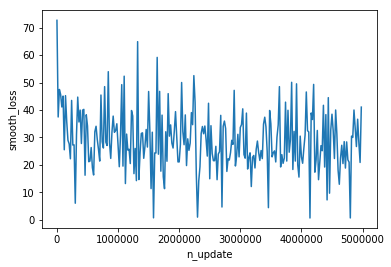

In [105]:
n_updates = 5000000
x = np.arange(0,n_updates,20000)
loss = np.squeeze(np.array(model16_1.loss_history))[x]
plotResults(x,loss,name='smooth_loss',save_name='bonus_5M_updates_20000')